In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import impute
from sklearn import pipeline

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)


import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [3]:
preproc_pipe = pipeline.Pipeline([
    ("imputer", impute.SimpleImputer(strategy="median")), 
    ("scaler", preprocessing.MaxAbsScaler()),
])

preproc_pipe.fit(train[input_cols])
display(preproc_pipe)

train[input_cols] = preproc_pipe.transform(train[input_cols])
test[input_cols] = preproc_pipe.transform(test[input_cols])

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MaxAbsScaler())])

In [4]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [5]:
def balanced_logloss_(y_pred, y_true):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, 1e-15, 1-1e-15)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / n0
    log_loss1 = - np.sum(y_true * np.log(p1)) / n1
    return (log_loss0 + log_loss1)/2

#def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
#    y_true = data.get_label()
#    return 'balanced_logloss', balanced_logloss_(y_pred, y_true), False 

In [6]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [7]:
DEFAULT_PARAMS = {
    "random_state":0,
    "solver":"liblinear", #fixed
    "max_iter":100000,
    "dual":False,
}

def train_validate(
        dataframe,
        input_cols, 
        model_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
    ):

    metrics = list()
    model_params = dict(model_params)

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)

            clf = LogisticRegression(**model_params)
            clf.fit(
                train_df[input_cols].values, 
                train_df["Class"].values, 
            )
            y_pred = clf.predict_proba(valid_df[input_cols].values)

            metrics.append( balanced_logloss_(y_pred[:,1], valid_df["Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    _model_params = dict(
        penalty = trial.suggest_categorical("penalty", ["l1", "l2"]),
        #dual = trial.suggest_categorical("dual", [True, False]),
        tol = 10**(trial.suggest_int("tol_exp", -10, -1)),
        C = trial.suggest_float("C", 1e-10, 1e2, log=True),
        fit_intercept = trial.suggest_categorical("fit_intercept", [True, False]),
        class_weight = trial.suggest_categorical("class_weight", ["balanced", None]),
    )
    model_params = {**DEFAULT_PARAMS, **_model_params}
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        model_params = model_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
    )
    
    return metric_mean

In [8]:
%%time
train_validate(
    dataframe = train,
    input_cols = input_cols,
    model_params = DEFAULT_PARAMS,
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False,
)

CPU times: user 499 ms, sys: 209 µs, total: 499 ms
Wall time: 498 ms


(0.6660111483704101, 0.056745563622254074)

In [9]:
do_optimize = True

study = optuna.create_study(
    study_name="iarc-logistic-regression",
    direction='minimize',
    storage='sqlite:///iarc-logistic-regression.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=1000, 
        timeout=43200, # 12 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-07-12 00:16:16,993] Using an existing study with name 'iarc-linear-regression' instead of creating a new one.


[I 2023-07-12 00:16:20,711] Trial 52 finished with value: 0.39325106992425424 and parameters: {'C': 3.7051049220060923, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 00:16:24,243] Trial 53 finished with value: 0.3912027473786964 and parameters: {'C': 3.242052358822645, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 00:16:37,967] Trial 54 finished with value: 0.554226656786604 and parameters: {'C': 43.323390695833105, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 00:16:38,654] Trial 55 finished with value: 0.6418630633717369 and parameters: {'C': 0.1106067004583104, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 00:16:47,177] Trial 56 finished with value: 0.45934436674317053 and parameters: {'C': 14.994242579221932, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 00:16:51,972] Trial 57 finished with value: 0.3902541586959423 and parameters: {'C': 2.811343222967527, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 00:16:53,395] Trial 58 finished with value: 0.6749679863138962 and parameters: {'C': 0.8662446404691854, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 00:16:54,121] Trial 59 finished with value: 0.6132793580207414 and parameters: {'C': 0.17024335255064052, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 00:17:26,052] Trial 60 finished with value: 0.6002192332775892 and parameters: {'C': 66.73420165607337, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 49 with value: 0.3901981971177242.


/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[I 2023-07-12 01:19:17,208] Trial 61 finished with value: 0.39033810743194486 and parameters: {'C': 2.8853331971720673, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 01:19:21,049] Trial 62 finished with value: 0.3903860848665241 and parameters: {'C': 2.560595892865116, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 01:21:22,641] Trial 63 finished with value: 0.43702362553900653 and parameters: {'C': 10.747730701998636, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 01:30:10,180] Trial 64 finished with value: 0.44325390506962337 and parameters: {'C': 0.9545934471849987, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -10}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 01:30:14,508] Trial 65 finished with value: 0.39039899603198286 and parameters: {'C': 2.920339088666604, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 01:30:15,411] Trial 66 finished with value: 0.5458031133407154 and parameters: {'C': 0.2963897308645966, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 01:30:16,223] Trial 67 finished with value: 0.42924549779102783 and parameters: {'C': 2.2785272819499975, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -6}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 01:30:31,060] Trial 68 finished with value: 0.4458968568719084 and parameters: {'C': 12.355659458213484, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 01:30:32,234] Trial 69 finished with value: 0.4673010448468549 and parameters: {'C': 0.7240989568083538, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 01:30:45,570] Trial 70 finished with value: 0.4836838394660411 and parameters: {'C': 20.52162752368854, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 01:30:48,114] Trial 71 finished with value: 0.5709520693483086 and parameters: {'C': 2.4025565643105162, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 01:30:52,525] Trial 72 finished with value: 0.3994211959604357 and parameters: {'C': 4.729197879203569, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 49 with value: 0.3901981971177242.


/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[I 2023-07-12 02:04:05,766] Trial 73 finished with value: 0.39361128551370944 and parameters: {'C': 2.1103881780323728, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 02:04:12,672] Trial 74 finished with value: 0.42087977489686323 and parameters: {'C': 8.062441670663373, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 02:04:13,675] Trial 75 finished with value: 0.4742517039022131 and parameters: {'C': 0.6628318287305862, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 02:04:27,546] Trial 76 finished with value: 0.5667941793902295 and parameters: {'C': 49.15217694287576, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 02:04:33,088] Trial 77 finished with value: 0.474429721366784 and parameters: {'C': 18.330741035775286, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 02:04:33,687] Trial 78 finished with value: 0.6765329351384967 and parameters: {'C': 0.05599596580158035, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 02:04:34,373] Trial 79 finished with value: 0.5360238630314419 and parameters: {'C': 0.2164755619063425, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -6}. Best is trial 49 with value: 0.3901981971177242.


[I 2023-07-12 02:04:37,949] Trial 80 finished with value: 0.3898078873129947 and parameters: {'C': 3.0588546883617767, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:05:51,334] Trial 81 finished with value: 0.4132166908221453 and parameters: {'C': 6.863117337305272, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:05:54,304] Trial 82 finished with value: 0.3921886304680916 and parameters: {'C': 2.1932948878951697, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:05:56,438] Trial 83 finished with value: 0.4272933484754474 and parameters: {'C': 1.183890366591593, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:05:59,552] Trial 84 finished with value: 0.390809921002926 and parameters: {'C': 3.4169268068492546, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:06:00,497] Trial 85 finished with value: 0.5250627895815015 and parameters: {'C': 0.364144739645436, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:06:04,503] Trial 86 finished with value: 0.4043980061205859 and parameters: {'C': 5.894133799750785, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:06:11,830] Trial 87 finished with value: 0.49035087698133867 and parameters: {'C': 24.085577469494392, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:06:12,843] Trial 88 finished with value: 0.49234740217690304 and parameters: {'C': 0.523371026684268, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:06:14,434] Trial 89 finished with value: 0.6292248714399782 and parameters: {'C': 1.267027284977666, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:06:18,822] Trial 90 finished with value: 0.3906542043881387 and parameters: {'C': 3.0394552468526372, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:06:32,119] Trial 91 finished with value: 0.6318861033370028 and parameters: {'C': 99.03636772202738, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -10}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:06:36,977] Trial 92 finished with value: 0.3934493854758264 and parameters: {'C': 3.7450272272553344, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:06:48,796] Trial 93 finished with value: 0.4298652330807783 and parameters: {'C': 9.536947990795973, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:06:52,914] Trial 94 finished with value: 0.39020500652448553 and parameters: {'C': 2.678609150102336, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:06:54,441] Trial 95 finished with value: 0.4401309794031152 and parameters: {'C': 0.9961785198835951, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:07:27,418] Trial 96 finished with value: 0.5364991097186601 and parameters: {'C': 36.11316320853075, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:07:28,277] Trial 97 finished with value: 0.42849589454285336 and parameters: {'C': 2.335999372528694, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:07:28,954] Trial 98 finished with value: 0.6167442624766915 and parameters: {'C': 0.16297502927122673, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:07:42,728] Trial 99 finished with value: 0.4544792139449932 and parameters: {'C': 13.999100582662278, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:07:43,690] Trial 100 finished with value: 0.5009174667318755 and parameters: {'C': 0.4735930913060395, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:07:50,370] Trial 101 finished with value: 0.4041595762523704 and parameters: {'C': 5.448390235269271, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:07:54,093] Trial 102 finished with value: 0.39291353041296595 and parameters: {'C': 3.6408196010945555, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:07:56,515] Trial 103 finished with value: 0.4087664385822551 and parameters: {'C': 1.5333864243073676, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:07:59,918] Trial 104 finished with value: 0.39062103764323547 and parameters: {'C': 3.0242916565425886, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:08:06,803] Trial 105 finished with value: 0.4218377839747479 and parameters: {'C': 8.214908298450952, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:08:08,000] Trial 106 finished with value: 0.4485184517887017 and parameters: {'C': 0.8923806180925429, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:08:20,051] Trial 107 finished with value: 0.5631997918305217 and parameters: {'C': 15.04610623557676, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 80 with value: 0.3898078873129947.


/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[I 2023-07-12 02:14:51,798] Trial 108 finished with value: 0.39139297446858073 and parameters: {'C': 3.294051096622304, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:14:52,717] Trial 109 finished with value: 0.5261930841666402 and parameters: {'C': 0.3597867845628148, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:14:53,413] Trial 110 finished with value: 0.4016499802299646 and parameters: {'C': 1.7243250011191138, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -1}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:14:54,669] Trial 111 finished with value: 0.43552545803209325 and parameters: {'C': 55.6317691472758, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:14:59,197] Trial 112 finished with value: 0.40906721726880657 and parameters: {'C': 6.214914161879434, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:15:02,614] Trial 113 finished with value: 0.39079677748038194 and parameters: {'C': 3.1018208454824627, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:15:03,674] Trial 114 finished with value: 0.4652653106676247 and parameters: {'C': 0.740164504533718, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:15:07,508] Trial 115 finished with value: 0.3903071306674196 and parameters: {'C': 2.595599088125959, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:15:23,270] Trial 116 finished with value: 0.5182625656555738 and parameters: {'C': 30.047078220982787, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:15:24,989] Trial 117 finished with value: 0.41847858572736946 and parameters: {'C': 1.3297263240933652, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:15:33,574] Trial 118 finished with value: 0.4323693103393806 and parameters: {'C': 9.950434470901172, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:15:35,349] Trial 119 finished with value: 0.39500182590838234 and parameters: {'C': 2.014126012699003, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:15:44,063] Trial 120 finished with value: 0.46513073594563714 and parameters: {'C': 16.221719149111014, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:15:44,782] Trial 121 finished with value: 0.8546401791155691 and parameters: {'C': 0.20595501245264763, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:15:50,113] Trial 122 finished with value: 0.3949963459743486 and parameters: {'C': 4.032139230843616, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:15:51,510] Trial 123 finished with value: 0.4840393121171114 and parameters: {'C': 0.5813972200502737, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:15:56,138] Trial 124 finished with value: 0.3902263132891126 and parameters: {'C': 2.652811285134141, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:15:59,690] Trial 125 finished with value: 0.3912382070927895 and parameters: {'C': 2.3620927614683476, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:16:04,525] Trial 126 finished with value: 0.41444352408446283 and parameters: {'C': 7.052796398718776, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:16:05,942] Trial 127 finished with value: 0.43225867795941625 and parameters: {'C': 1.109831583393333, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:16:12,479] Trial 128 finished with value: 0.40221801619125985 and parameters: {'C': 5.153873196912899, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:16:26,444] Trial 129 finished with value: 0.49836959366203815 and parameters: {'C': 24.317537118774858, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:16:28,719] Trial 130 finished with value: 0.39027109862727516 and parameters: {'C': 2.843033437186659, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:16:29,409] Trial 131 finished with value: 0.4717689936016645 and parameters: {'C': 0.7669404825905376, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:16:31,662] Trial 132 finished with value: 0.39029043097830607 and parameters: {'C': 2.859804220492553, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:16:33,060] Trial 133 finished with value: 0.3950641812815869 and parameters: {'C': 2.0077284402046183, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:16:37,134] Trial 134 finished with value: 0.43351700570095575 and parameters: {'C': 10.1483635105565, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:16:37,824] Trial 135 finished with value: 0.5227801476019198 and parameters: {'C': 0.37414966481594003, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -2}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:16:39,196] Trial 136 finished with value: 0.41792084367985827 and parameters: {'C': 1.339645178861553, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:16:45,116] Trial 137 finished with value: 0.40717198036088176 and parameters: {'C': 5.918716631913814, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:16:47,412] Trial 138 finished with value: 0.3905396845117099 and parameters: {'C': 2.994091137832207, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:16:52,141] Trial 139 finished with value: 0.45016063051077415 and parameters: {'C': 13.167701039093961, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:16:54,324] Trial 140 finished with value: 0.3902221126540868 and parameters: {'C': 2.6460392792326575, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:16:54,975] Trial 141 finished with value: 0.643613098619307 and parameters: {'C': 0.10802126432331347, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:16:56,876] Trial 142 finished with value: 0.39258348921628355 and parameters: {'C': 2.195148153719565, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:16:59,856] Trial 143 finished with value: 0.39808866986462893 and parameters: {'C': 4.534121005190025, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:17:00,999] Trial 144 finished with value: 0.436869792522393 and parameters: {'C': 1.0421262350296339, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:17:03,239] Trial 145 finished with value: 0.39027176920858303 and parameters: {'C': 2.8437876084109397, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:17:06,664] Trial 146 finished with value: 0.42047937520075573 and parameters: {'C': 8.002259171203972, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:17:07,518] Trial 147 finished with value: 0.4927475230325846 and parameters: {'C': 0.5208435129050992, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:17:08,296] Trial 148 finished with value: 0.6135318108148493 and parameters: {'C': 1.463907464890984, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:17:08,998] Trial 149 finished with value: 0.5499838571468537 and parameters: {'C': 0.28525000677616824, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:17:11,199] Trial 150 finished with value: 0.3902017865910593 and parameters: {'C': 2.6704442445689205, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:17:12,104] Trial 151 finished with value: 0.4736428200629799 and parameters: {'C': 0.6685553621716257, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:17:14,347] Trial 152 finished with value: 0.39020179164242563 and parameters: {'C': 2.7487248627594774, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:17:17,316] Trial 153 finished with value: 0.4004051670201788 and parameters: {'C': 4.879974064967468, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:17:18,725] Trial 154 finished with value: 0.4138269805635183 and parameters: {'C': 1.4185768017185874, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:17:20,873] Trial 155 finished with value: 0.3902858395688924 and parameters: {'C': 2.6010056336151623, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:17:26,810] Trial 156 finished with value: 0.48635009202993545 and parameters: {'C': 21.198398107891933, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:17:27,383] Trial 157 finished with value: 0.6931471805599455 and parameters: {'C': 0.00010407292391719818, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:00,051] Trial 158 finished with value: 0.4278623926146718 and parameters: {'C': 9.209311465157331, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:00,883] Trial 159 finished with value: 0.43338604356120547 and parameters: {'C': 1.998393731738558, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -10}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:01,898] Trial 160 finished with value: 0.4526602606622569 and parameters: {'C': 0.8483006856329427, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:02,459] Trial 161 finished with value: 0.6931471805599455 and parameters: {'C': 0.01384111345552299, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:04,981] Trial 162 finished with value: 0.39164146739912903 and parameters: {'C': 3.36431775347192, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:07,264] Trial 163 finished with value: 0.39027797840206974 and parameters: {'C': 2.8499167658125515, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:10,289] Trial 164 finished with value: 0.40381610127418816 and parameters: {'C': 5.397304453687848, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:11,684] Trial 165 finished with value: 0.415136410288598 and parameters: {'C': 1.3918676839616981, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:13,178] Trial 166 finished with value: 0.39215649367105293 and parameters: {'C': 2.2377003108286564, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:16,583] Trial 167 finished with value: 0.4182590589617443 and parameters: {'C': 7.651967693402336, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:33,428] Trial 168 finished with value: 0.4573112761770568 and parameters: {'C': 14.572799598282904, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:39,750] Trial 169 finished with value: 0.396443276226923 and parameters: {'C': 4.276606244587448, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:40,307] Trial 170 finished with value: 0.6931471805599455 and parameters: {'C': 0.003941171124145449, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:41,039] Trial 171 finished with value: 0.6965899236907472 and parameters: {'C': 0.7220645497644348, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:43,266] Trial 172 finished with value: 0.3902315406470741 and parameters: {'C': 2.7899085130167385, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:45,123] Trial 173 finished with value: 0.3932333999350338 and parameters: {'C': 2.1383611370862323, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:46,486] Trial 174 finished with value: 0.42028070761623426 and parameters: {'C': 1.2981149350379932, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:49,613] Trial 175 finished with value: 0.40898807792580244 and parameters: {'C': 6.20413204289428, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:52,073] Trial 176 finished with value: 0.39135330323856393 and parameters: {'C': 3.2865508851692034, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:55,625] Trial 177 finished with value: 0.4301402690792843 and parameters: {'C': 10.31612904199527, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:56,401] Trial 178 finished with value: 0.49936524609159966 and parameters: {'C': 0.48214407617605837, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:58,273] Trial 179 finished with value: 0.39263890027556303 and parameters: {'C': 2.189649844179558, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:22:58,826] Trial 180 finished with value: 0.6931471805599455 and parameters: {'C': 9.73660740303631e-07, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:05,029] Trial 181 finished with value: 0.395624001772824 and parameters: {'C': 4.139804763186927, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:07,320] Trial 182 finished with value: 0.3904938755783847 and parameters: {'C': 2.973811397876612, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:08,474] Trial 183 finished with value: 0.4386712895177229 and parameters: {'C': 1.0165187136297689, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:10,648] Trial 184 finished with value: 0.3901972647608348 and parameters: {'C': 2.676336350008428, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:12,229] Trial 185 finished with value: 0.4042335508721978 and parameters: {'C': 1.6538847114374733, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:15,301] Trial 186 finished with value: 0.40626460180328594 and parameters: {'C': 5.776580224436624, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:16,724] Trial 187 finished with value: 0.4459354703949741 and parameters: {'C': 0.9213331167280651, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:17,739] Trial 188 finished with value: 0.4099905186452404 and parameters: {'C': 12.859875208193456, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:19,572] Trial 189 finished with value: 0.39363442940369564 and parameters: {'C': 2.107995412613637, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:29,095] Trial 190 finished with value: 0.5165732340645506 and parameters: {'C': 32.09633012182651, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:29,744] Trial 191 finished with value: 0.6669825215341713 and parameters: {'C': 0.06669657134180161, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -10}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:32,260] Trial 192 finished with value: 0.3918866027002549 and parameters: {'C': 3.4257696070264263, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:34,615] Trial 193 finished with value: 0.39084388522856306 and parameters: {'C': 3.1261546223546297, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:37,646] Trial 194 finished with value: 0.4029920460929485 and parameters: {'C': 5.272580520328808, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:39,183] Trial 195 finished with value: 0.40930812169950764 and parameters: {'C': 1.5202473363267075, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:41,674] Trial 196 finished with value: 0.4152621155690796 and parameters: {'C': 7.198907327861475, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:44,036] Trial 197 finished with value: 0.3906900534584231 and parameters: {'C': 3.061027336044075, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:45,175] Trial 198 finished with value: 0.43448976586383503 and parameters: {'C': 1.0766694424492804, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:46,046] Trial 199 finished with value: 0.5159796394191676 and parameters: {'C': 0.4017492223856164, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:49,285] Trial 200 finished with value: 0.39255336600350704 and parameters: {'C': 2.199033009631117, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:53,337] Trial 201 finished with value: 0.43361463925624394 and parameters: {'C': 10.165024537346433, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:55,722] Trial 202 finished with value: 0.3906251116205569 and parameters: {'C': 3.0308681030847797, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:23:58,760] Trial 203 finished with value: 0.4033333442408447 and parameters: {'C': 5.324076480450321, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:00,943] Trial 204 finished with value: 0.3902059282510119 and parameters: {'C': 2.6649192555912036, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:02,348] Trial 205 finished with value: 0.41282564130055405 and parameters: {'C': 1.4399950892230617, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:04,295] Trial 206 finished with value: 0.39169333629692743 and parameters: {'C': 2.2950285116336984, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:05,344] Trial 207 finished with value: 0.47001445890586074 and parameters: {'C': 0.7009192374324479, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:06,723] Trial 208 finished with value: 0.5417711910154209 and parameters: {'C': 3.970984306061055, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:10,321] Trial 209 finished with value: 0.42295736016577684 and parameters: {'C': 8.399706661590557, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:11,881] Trial 210 finished with value: 0.434058111250066 and parameters: {'C': 1.082770150640708, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:13,495] Trial 211 finished with value: 0.4021211746502912 and parameters: {'C': 1.7167532588195482, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:15,757] Trial 212 finished with value: 0.3902513570975922 and parameters: {'C': 2.8221066550915617, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:18,713] Trial 213 finished with value: 0.39886670869688734 and parameters: {'C': 4.647626228003103, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:21,109] Trial 214 finished with value: 0.3908654257066216 and parameters: {'C': 3.1339426708313693, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:23,065] Trial 215 finished with value: 0.39121315953980257 and parameters: {'C': 2.364352364007746, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:26,309] Trial 216 finished with value: 0.4115345422641965 and parameters: {'C': 6.60249571963651, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:39,435] Trial 217 finished with value: 0.47372625630426923 and parameters: {'C': 18.150945760229458, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:40,622] Trial 218 finished with value: 0.4135117316243066 and parameters: {'C': 1.4248731514093926, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:41,526] Trial 219 finished with value: 0.47376936394706315 and parameters: {'C': 0.6673597882906384, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:42,161] Trial 220 finished with value: 0.641083444574701 and parameters: {'C': 0.02324124871689602, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:48,814] Trial 221 finished with value: 0.39873821732034925 and parameters: {'C': 4.6281919450268605, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:51,335] Trial 222 finished with value: 0.3917153733661401 and parameters: {'C': 3.3832212128039068, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:53,297] Trial 223 finished with value: 0.3916011601101294 and parameters: {'C': 2.306958691239713, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:24:54,906] Trial 224 finished with value: 0.4026985409152673 and parameters: {'C': 1.6990362206890706, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:25:59,544] Trial 225 finished with value: 0.4200352949090179 and parameters: {'C': 7.928376973803714, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:26:01,933] Trial 226 finished with value: 0.3907988761184945 and parameters: {'C': 3.1060185025586073, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:26:03,081] Trial 227 finished with value: 0.43677338282764844 and parameters: {'C': 1.0435192361442533, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:26:06,096] Trial 228 finished with value: 0.4021556707029337 and parameters: {'C': 5.14502462714037, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:26:06,650] Trial 229 finished with value: 0.6931471805599455 and parameters: {'C': 0.007765225606508496, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:26:10,340] Trial 230 finished with value: 0.39069968893875845 and parameters: {'C': 2.469718795184726, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:26:11,001] Trial 231 finished with value: 0.6037042684080535 and parameters: {'C': 0.18533817436854752, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:26:14,002] Trial 232 finished with value: 0.3904012861894076 and parameters: {'C': 2.554875591762357, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:26:14,562] Trial 233 finished with value: 0.6931471805599455 and parameters: {'C': 0.0007408485081597481, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:26:16,989] Trial 234 finished with value: 0.3943067457080464 and parameters: {'C': 2.0601985290647864, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:26:18,337] Trial 235 finished with value: 0.42003789373409034 and parameters: {'C': 1.3022872283929168, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:26:21,078] Trial 236 finished with value: 0.3945200817635778 and parameters: {'C': 3.947376042007241, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:26:41,241] Trial 237 finished with value: 0.5855255668037987 and parameters: {'C': 58.71104523300443, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:26:45,513] Trial 238 finished with value: 0.4366271443624269 and parameters: {'C': 10.682823014023034, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:26:48,800] Trial 239 finished with value: 0.39032163040536416 and parameters: {'C': 2.8751053493805037, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:26:51,293] Trial 240 finished with value: 0.5385098105455418 and parameters: {'C': 5.929167589693954, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:26:53,354] Trial 241 finished with value: 0.40570530633341195 and parameters: {'C': 1.6123711047279374, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:26:56,571] Trial 242 finished with value: 0.39026400699542485 and parameters: {'C': 2.826209042939007, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:26:59,804] Trial 243 finished with value: 0.3902418850142687 and parameters: {'C': 2.7919373856140313, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:03,598] Trial 244 finished with value: 0.3937731416713002 and parameters: {'C': 3.807869025462954, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:04,793] Trial 245 finished with value: 0.4498047280765337 and parameters: {'C': 0.8777039597297692, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:07,034] Trial 246 finished with value: 0.39802918432438156 and parameters: {'C': 1.8657249446539912, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:11,750] Trial 247 finished with value: 0.4117784237618374 and parameters: {'C': 6.640126002005594, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:12,305] Trial 248 finished with value: 0.6931471805599455 and parameters: {'C': 4.5487255782624657e-10, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:15,394] Trial 249 finished with value: 0.3902638194912214 and parameters: {'C': 2.6209084477717557, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:16,747] Trial 250 finished with value: 0.4392874380260991 and parameters: {'C': 1.00790343233779, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:19,766] Trial 251 finished with value: 0.3948354849658447 and parameters: {'C': 4.278072341820067, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:21,787] Trial 252 finished with value: 0.40863823822971207 and parameters: {'C': 1.536514912718434, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:22,746] Trial 253 finished with value: 0.48910344817635365 and parameters: {'C': 0.544737523828863, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:23,726] Trial 254 finished with value: 0.4099836658097775 and parameters: {'C': 12.847007402753555, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:26,912] Trial 255 finished with value: 0.39019635452023205 and parameters: {'C': 2.716323793985823, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:31,416] Trial 256 finished with value: 0.4043784437954531 and parameters: {'C': 5.482082403514209, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:38,091] Trial 257 finished with value: 0.3911683710152854 and parameters: {'C': 2.3735899666956097, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:39,768] Trial 258 finished with value: 0.4211136267851186 and parameters: {'C': 1.284034063514439, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:43,361] Trial 259 finished with value: 0.39191541342433067 and parameters: {'C': 3.4302161803144213, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:49,099] Trial 260 finished with value: 0.42594212920662505 and parameters: {'C': 8.889867658068779, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:51,403] Trial 261 finished with value: 0.3969147031765907 and parameters: {'C': 1.9149972876797239, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:52,677] Trial 262 finished with value: 0.46569818417100256 and parameters: {'C': 0.7367194147965339, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:27:57,045] Trial 263 finished with value: 0.5418168219735751 and parameters: {'C': 0.3076952806577322, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:01,453] Trial 264 finished with value: 0.4005767251864673 and parameters: {'C': 4.90500953036243, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:02,006] Trial 265 finished with value: 0.6931471805599455 and parameters: {'C': 3.445411391233555e-05, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:04,256] Trial 266 finished with value: 0.3902329616411094 and parameters: {'C': 2.7939222101907317, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:06,587] Trial 267 finished with value: 0.3905751413261242 and parameters: {'C': 3.0092749955963067, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:10,059] Trial 268 finished with value: 0.4218587692009973 and parameters: {'C': 8.22184480664633, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:11,387] Trial 269 finished with value: 0.4210306687772112 and parameters: {'C': 1.2853864165995472, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:14,270] Trial 270 finished with value: 0.3963832445519446 and parameters: {'C': 4.267882219306228, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:14,840] Trial 271 finished with value: 0.6931471805599455 and parameters: {'C': 0.02484743365268336, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:15,400] Trial 272 finished with value: 0.6930691096192407 and parameters: {'C': 0.03532660049068198, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:15,964] Trial 273 finished with value: 0.6931471805599455 and parameters: {'C': 5.701515943202719e-09, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:16,743] Trial 274 finished with value: 0.4328814488105109 and parameters: {'C': 2.0295424413290575, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:24,420] Trial 275 finished with value: 0.44920722203892927 and parameters: {'C': 12.978263889464184, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:28,203] Trial 276 finished with value: 0.6118286900366149 and parameters: {'C': 82.47209853687893, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:33,745] Trial 277 finished with value: 0.4732142911662896 and parameters: {'C': 18.047600505115042, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:34,613] Trial 278 finished with value: 0.4594360655685133 and parameters: {'C': 0.7897992892028014, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:39,519] Trial 279 finished with value: 0.3903411157945842 and parameters: {'C': 2.8872016328956116, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:42,833] Trial 280 finished with value: 0.41548118599493533 and parameters: {'C': 7.217634497905424, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:43,756] Trial 281 finished with value: 0.5093820479440297 and parameters: {'C': 0.431473953350657, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:44,382] Trial 282 finished with value: 0.6280226088952293 and parameters: {'C': 0.13373935947261834, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:46,437] Trial 283 finished with value: 0.4048808336240191 and parameters: {'C': 1.6356155336565605, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:49,435] Trial 284 finished with value: 0.3983869290937884 and parameters: {'C': 4.5777757763300455, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:50,245] Trial 285 finished with value: 0.6595655672504797 and parameters: {'C': 0.9960343844069096, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:28:50,835] Trial 286 finished with value: 0.6638024752805218 and parameters: {'C': 0.07176007451685679, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:01,882] Trial 287 finished with value: 0.5120771098782473 and parameters: {'C': 28.16634565251079, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:03,958] Trial 288 finished with value: 0.39033706679682806 and parameters: {'C': 2.575282091756158, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:05,822] Trial 289 finished with value: 0.39352921921316103 and parameters: {'C': 2.11588888365124, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:08,890] Trial 290 finished with value: 0.40503946478617414 and parameters: {'C': 5.585002765700048, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:11,342] Trial 291 finished with value: 0.3910260667920501 and parameters: {'C': 3.1933790358123226, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:11,923] Trial 292 finished with value: 0.68588318089089 and parameters: {'C': 0.04766977631112037, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:13,247] Trial 293 finished with value: 0.4213027223265452 and parameters: {'C': 1.2808693524709054, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:13,970] Trial 294 finished with value: 0.48389414954958554 and parameters: {'C': 0.5940693747650225, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:17,424] Trial 295 finished with value: 0.42140144231643945 and parameters: {'C': 8.149150230646557, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:19,477] Trial 296 finished with value: 0.39061795931015647 and parameters: {'C': 2.4874505654355943, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:23,533] Trial 297 finished with value: 0.39475637759231175 and parameters: {'C': 3.9895351055709614, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:24,119] Trial 298 finished with value: 0.6931471805599455 and parameters: {'C': 0.007977294603478482, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:25,655] Trial 299 finished with value: 0.40932086732538947 and parameters: {'C': 1.5199451516683191, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:26,742] Trial 300 finished with value: 0.44412528362038733 and parameters: {'C': 0.9434634860239085, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:27,432] Trial 301 finished with value: 0.5681744116195179 and parameters: {'C': 0.2430367550563193, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:41,011] Trial 302 finished with value: 0.5496600089112693 and parameters: {'C': 41.333325040136145, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:41,570] Trial 303 finished with value: 0.6931471805599455 and parameters: {'C': 0.0018392249815898096, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:46,058] Trial 304 finished with value: 0.4424767145244369 and parameters: {'C': 11.732526183444014, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:48,543] Trial 305 finished with value: 0.5383957293867694 and parameters: {'C': 5.856890283167351, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:52,477] Trial 306 finished with value: 0.39161214190431637 and parameters: {'C': 2.306771231051229, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:54,801] Trial 307 finished with value: 0.3905654621819575 and parameters: {'C': 3.005036908580481, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:56,546] Trial 308 finished with value: 0.4174235531577243 and parameters: {'C': 1.3487480413419874, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:29:59,375] Trial 309 finished with value: 0.39604781057463306 and parameters: {'C': 4.212572219722934, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:02,390] Trial 310 finished with value: 0.46619994618872573 and parameters: {'C': 17.85915516718676, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:03,275] Trial 311 finished with value: 0.4791006078775322 and parameters: {'C': 0.6203128575026481, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:05,838] Trial 312 finished with value: 0.4136291802551675 and parameters: {'C': 6.9421868247324605, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:06,632] Trial 313 finished with value: 0.428875059049592 and parameters: {'C': 2.3066354714445736, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:07,194] Trial 314 finished with value: 0.6931471805599455 and parameters: {'C': 7.292723767449564e-06, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:07,764] Trial 315 finished with value: 0.6931471805599455 and parameters: {'C': 2.0886093252657688e-08, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:09,336] Trial 316 finished with value: 0.40565156377664296 and parameters: {'C': 1.6136602097336403, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:09,901] Trial 317 finished with value: 0.6931471805599455 and parameters: {'C': 0.018585522666879486, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:10,458] Trial 318 finished with value: 0.6931471805599455 and parameters: {'C': 0.0007786539740653073, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:11,018] Trial 319 finished with value: 0.6931471805599455 and parameters: {'C': 0.00024784382394573063, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:11,570] Trial 320 finished with value: 0.6931471805599455 and parameters: {'C': 0.003929156813033274, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:14,016] Trial 321 finished with value: 0.3925899433125465 and parameters: {'C': 3.834483405874823, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:15,080] Trial 322 finished with value: 0.4455675582511136 and parameters: {'C': 0.9257355369045546, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:15,994] Trial 323 finished with value: 0.529733110993154 and parameters: {'C': 0.34663235706484896, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:19,401] Trial 324 finished with value: 0.4187546535031514 and parameters: {'C': 7.7292765176744345, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:21,923] Trial 325 finished with value: 0.5879505744585242 and parameters: {'C': 1.9607405290262292, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:24,421] Trial 326 finished with value: 0.3917334344310385 and parameters: {'C': 3.3879201858245853, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:28,899] Trial 327 finished with value: 0.4014234326442881 and parameters: {'C': 5.033451939856787, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:32,045] Trial 328 finished with value: 0.44274858287078417 and parameters: {'C': 11.816188572988985, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:32,617] Trial 329 finished with value: 0.6931471805599455 and parameters: {'C': 3.189746804513869e-07, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:33,837] Trial 330 finished with value: 0.43142657290255715 and parameters: {'C': 1.122189928316529, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:35,712] Trial 331 finished with value: 0.3923175569158417 and parameters: {'C': 2.2228449660831, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:36,358] Trial 332 finished with value: 0.5905623993331769 and parameters: {'C': 0.07569167271708545, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:37,211] Trial 333 finished with value: 0.4901839864384406 and parameters: {'C': 0.5374703668723542, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:40,170] Trial 334 finished with value: 0.4039464739231211 and parameters: {'C': 5.817876973976755, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:53,585] Trial 335 finished with value: 0.4842617035938591 and parameters: {'C': 20.662724368142936, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:55,152] Trial 336 finished with value: 0.40622329288584635 and parameters: {'C': 1.5982073685381513, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:57,484] Trial 337 finished with value: 0.3905884236803695 and parameters: {'C': 3.014963665251221, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:58,627] Trial 338 finished with value: 0.4403094709239644 and parameters: {'C': 0.9937310873667639, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:30:59,513] Trial 339 finished with value: 0.5939843412828021 and parameters: {'C': 0.19974281591607984, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:04,660] Trial 340 finished with value: 0.4212180934216013 and parameters: {'C': 8.116423384601127, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:07,332] Trial 341 finished with value: 0.39385023045492246 and parameters: {'C': 3.8246441332407, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:09,010] Trial 342 finished with value: 0.40093477366773655 and parameters: {'C': 1.7551210599570592, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:10,804] Trial 343 finished with value: 0.5625301664800019 and parameters: {'C': 2.6780791027268345, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:14,217] Trial 344 finished with value: 0.40025735859794587 and parameters: {'C': 5.201552055137765, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:15,197] Trial 345 finished with value: 0.46555329785656885 and parameters: {'C': 0.7378727402922954, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:20,870] Trial 346 finished with value: 0.5880900805543803 and parameters: {'C': 60.38091542822591, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:28,213] Trial 347 finished with value: 0.4447301879167126 and parameters: {'C': 12.140040392567043, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:30,568] Trial 348 finished with value: 0.4168609942085136 and parameters: {'C': 1.3591310753348986, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:32,876] Trial 349 finished with value: 0.390541672677341 and parameters: {'C': 2.995037071850931, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:33,431] Trial 350 finished with value: 0.6931471805599455 and parameters: {'C': 0.014667685829764297, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:33,999] Trial 351 finished with value: 0.6931471805599455 and parameters: {'C': 3.8907372105386554e-10, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:34,802] Trial 352 finished with value: 0.41078619118659804 and parameters: {'C': 5.57408769217773, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:35,439] Trial 353 finished with value: 0.6465875502323892 and parameters: {'C': 0.10314724248100238, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:51,319] Trial 354 finished with value: 0.5201011942961231 and parameters: {'C': 30.635411515449494, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:51,897] Trial 355 finished with value: 0.6931471805599455 and parameters: {'C': 3.5725004806109083e-06, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:52,449] Trial 356 finished with value: 0.6931471805599455 and parameters: {'C': 0.00037844342353652747, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:53,389] Trial 357 finished with value: 0.4985137680737249 and parameters: {'C': 0.4868027096185233, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:53,967] Trial 358 finished with value: 0.6931471805599455 and parameters: {'C': 0.00012196474924021345, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:31:57,035] Trial 359 finished with value: 0.3979557414346387 and parameters: {'C': 1.8686579392630212, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:00,872] Trial 360 finished with value: 0.42801530184972825 and parameters: {'C': 9.239460555176594, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:01,437] Trial 361 finished with value: 0.6931471805599455 and parameters: {'C': 0.001264335216891169, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:02,785] Trial 362 finished with value: 0.5428369461038222 and parameters: {'C': 3.8412329086001216, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:03,335] Trial 363 finished with value: 0.6931471805599455 and parameters: {'C': 6.75578438432847e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:03,897] Trial 364 finished with value: 0.6931471805599455 and parameters: {'C': 0.003221305306697712, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:04,933] Trial 365 finished with value: 0.4315910512143632 and parameters: {'C': 1.1195395779846498, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:06,954] Trial 366 finished with value: 0.3908080595665762 and parameters: {'C': 2.4415847713837193, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:08,051] Trial 367 finished with value: 0.4611848269939932 and parameters: {'C': 0.7744428794967976, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:11,101] Trial 368 finished with value: 0.404099722058815 and parameters: {'C': 5.439828032534678, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:11,667] Trial 369 finished with value: 0.6931471805599455 and parameters: {'C': 0.002897652636760905, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:13,202] Trial 370 finished with value: 0.40786511887397936 and parameters: {'C': 1.5558667344901085, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:13,801] Trial 371 finished with value: 0.664306169836693 and parameters: {'C': 0.010335401693175667, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:14,392] Trial 372 finished with value: 0.6824590671245897 and parameters: {'C': 0.05083444733634842, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:14,968] Trial 373 finished with value: 0.6931471805599455 and parameters: {'C': 0.0012370809344599651, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:15,541] Trial 374 finished with value: 0.6931471805599455 and parameters: {'C': 0.030484671082286002, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:19,054] Trial 375 finished with value: 0.39155440897897137 and parameters: {'C': 3.3384234668874724, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:19,610] Trial 376 finished with value: 0.6931471805599455 and parameters: {'C': 1.4697572523777706e-07, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:24,706] Trial 377 finished with value: 0.4177275484637493 and parameters: {'C': 7.566550497221008, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:27,631] Trial 378 finished with value: 0.45204759495454716 and parameters: {'C': 14.681474649146267, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:28,330] Trial 379 finished with value: 0.3934250838281313 and parameters: {'C': 2.0512256048614983, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -1}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:34,576] Trial 380 finished with value: 0.6378872024272746 and parameters: {'C': 93.74171845181154, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:35,339] Trial 381 finished with value: 0.5693441138548293 and parameters: {'C': 0.24064546055908362, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:38,669] Trial 382 finished with value: 0.5469312302384585 and parameters: {'C': 3.450647035694522, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:39,256] Trial 383 finished with value: 0.6931471805599455 and parameters: {'C': 3.056137580248895e-08, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:40,612] Trial 384 finished with value: 0.4493224940155392 and parameters: {'C': 0.8831208903561159, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:41,178] Trial 385 finished with value: 0.6931471805599455 and parameters: {'C': 0.005897063235556534, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:42,722] Trial 386 finished with value: 0.40807638887149017 and parameters: {'C': 1.5504725984231025, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:47,224] Trial 387 finished with value: 0.40535524898711883 and parameters: {'C': 5.633080989984467, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:53,080] Trial 388 finished with value: 0.4830209290934786 and parameters: {'C': 20.37860864587712, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:53,798] Trial 389 finished with value: 0.5151434252588548 and parameters: {'C': 0.4060706163697331, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -2}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:32:54,558] Trial 390 finished with value: 0.4213802366511657 and parameters: {'C': 2.922370535990472, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:33:06,595] Trial 391 finished with value: 0.4304503963912096 and parameters: {'C': 9.632646463309273, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:33:07,259] Trial 392 finished with value: 0.6321517409814819 and parameters: {'C': 0.12587852766206908, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:33:08,591] Trial 393 finished with value: 0.4237046787006738 and parameters: {'C': 1.2414698400323791, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:33:12,973] Trial 394 finished with value: 0.3976957761219553 and parameters: {'C': 4.474525703763188, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:33:16,233] Trial 395 finished with value: 0.39305309450794157 and parameters: {'C': 2.153708716190194, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:33:17,123] Trial 396 finished with value: 0.47822479043023447 and parameters: {'C': 0.6276014944086883, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:33:17,694] Trial 397 finished with value: 0.6931471805599455 and parameters: {'C': 0.008912462430344315, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:33:18,258] Trial 398 finished with value: 0.6931471805599455 and parameters: {'C': 0.00024808781833443334, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 02:33:21,141] Trial 399 finished with value: 0.39075874433554036 and parameters: {'C': 2.4555795546647303, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[I 2023-07-12 03:03:48,046] Trial 400 finished with value: 0.42036454740812784 and parameters: {'C': 7.980524933744244, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:03:53,084] Trial 401 finished with value: 0.6188251621594992 and parameters: {'C': 40.00445946420843, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:03:55,951] Trial 402 finished with value: 0.3968911852560415 and parameters: {'C': 4.350774819223156, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:03:57,323] Trial 403 finished with value: 0.4228447168919761 and parameters: {'C': 1.2554469481243453, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:00,573] Trial 404 finished with value: 0.39260121713581 and parameters: {'C': 2.1942700672912556, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:03,535] Trial 405 finished with value: 0.3976959973598251 and parameters: {'C': 4.475473775101074, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:11,652] Trial 406 finished with value: 0.45220792733964305 and parameters: {'C': 13.554955594975176, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:12,658] Trial 407 finished with value: 0.43769244641164007 and parameters: {'C': 1.0304087222345222, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:13,486] Trial 408 finished with value: 0.5136185845558123 and parameters: {'C': 0.41211584948088853, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:14,076] Trial 409 finished with value: 0.6931422859406164 and parameters: {'C': 1.278219867172992e-06, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:16,392] Trial 410 finished with value: 0.390412384491903 and parameters: {'C': 2.9334410240423345, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:16,987] Trial 411 finished with value: 0.6931471805599455 and parameters: {'C': 9.24744944943045e-06, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:19,332] Trial 412 finished with value: 0.4075283253072158 and parameters: {'C': 6.4210265462635, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:19,903] Trial 413 finished with value: 0.6931471805599455 and parameters: {'C': 3.0920310138637965e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:21,459] Trial 414 finished with value: 0.4061433764683649 and parameters: {'C': 1.6003465139843505, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:22,611] Trial 415 finished with value: 0.4598504471349644 and parameters: {'C': 0.786306442942697, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:27,387] Trial 416 finished with value: 0.39323699101371945 and parameters: {'C': 3.7021083887166464, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:30,885] Trial 417 finished with value: 0.4219195113928525 and parameters: {'C': 8.231549727551258, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:31,460] Trial 418 finished with value: 0.6931471805599455 and parameters: {'C': 0.0004455039609083596, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:33,114] Trial 419 finished with value: 0.40074066471396697 and parameters: {'C': 1.761711934516669, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:35,680] Trial 420 finished with value: 0.5818248879603583 and parameters: {'C': 21.61577703137767, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:36,251] Trial 421 finished with value: 0.6931471805599455 and parameters: {'C': 2.570597620868398e-09, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:38,256] Trial 422 finished with value: 0.39089455264613493 and parameters: {'C': 2.423180203241743, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:42,293] Trial 423 finished with value: 0.39548835973263335 and parameters: {'C': 4.116978690740583, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:43,786] Trial 424 finished with value: 0.43686798185018 and parameters: {'C': 1.0418887201530613, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:46,911] Trial 425 finished with value: 0.443172853878134 and parameters: {'C': 11.884426365144344, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:47,493] Trial 426 finished with value: 0.6931471805599455 and parameters: {'C': 0.0007452485359441629, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:50,557] Trial 427 finished with value: 0.4086118882936205 and parameters: {'C': 6.146003336662563, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:51,131] Trial 428 finished with value: 0.6931471805599455 and parameters: {'C': 0.0029519059847010042, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:51,851] Trial 429 finished with value: 0.4843037897584065 and parameters: {'C': 0.5890926654008426, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:55,208] Trial 430 finished with value: 0.3951652588988488 and parameters: {'C': 2.005183756694658, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:57,601] Trial 431 finished with value: 0.39076474689432045 and parameters: {'C': 3.093336066935013, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:58,903] Trial 432 finished with value: 0.4254604725062164 and parameters: {'C': 1.2133191430035264, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:04:59,587] Trial 433 finished with value: 0.6143321812172413 and parameters: {'C': 0.16814871320806726, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:05:00,340] Trial 434 finished with value: 0.5453696941244117 and parameters: {'C': 0.2975794651440492, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 03:05:03,268] Trial 435 finished with value: 0.403352813955244 and parameters: {'C': 5.717327087159073, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[I 2023-07-12 04:41:56,373] Trial 436 finished with value: 0.39041953878629493 and parameters: {'C': 2.931600572447881, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -10}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:41:58,873] Trial 437 finished with value: 0.4057146646057382 and parameters: {'C': 1.6121259822871186, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:02,803] Trial 438 finished with value: 0.4311880419361429 and parameters: {'C': 9.759566319848059, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:04,460] Trial 439 finished with value: 0.6029701689765973 and parameters: {'C': 31.24932165951622, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:05,040] Trial 440 finished with value: 0.6931471805599455 and parameters: {'C': 0.005640701905466699, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:05,604] Trial 441 finished with value: 0.6931471805599455 and parameters: {'C': 1.0490233477834444e-10, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:09,773] Trial 442 finished with value: 0.39530357636154967 and parameters: {'C': 4.085509625816187, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:12,927] Trial 443 finished with value: 0.3962555618878488 and parameters: {'C': 1.94717396096745, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:14,102] Trial 444 finished with value: 0.45681843025547175 and parameters: {'C': 0.8115826734370633, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:14,675] Trial 445 finished with value: 0.6931471805599455 and parameters: {'C': 6.215947359488142e-07, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:19,572] Trial 446 finished with value: 0.40621081902964207 and parameters: {'C': 6.199959782974849, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:20,197] Trial 447 finished with value: 0.6529974655224905 and parameters: {'C': 0.01601515514194786, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:20,753] Trial 448 finished with value: 0.6931471805599455 and parameters: {'C': 0.00016875943530802033, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:21,336] Trial 449 finished with value: 0.6931471805599455 and parameters: {'C': 0.0020154264277965996, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:21,914] Trial 450 finished with value: 0.6931471805599455 and parameters: {'C': 0.02677310978378033, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:24,169] Trial 451 finished with value: 0.3902354611444476 and parameters: {'C': 2.7993097867855807, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:29,246] Trial 452 finished with value: 0.46106334067162236 and parameters: {'C': 15.363751613241625, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:30,865] Trial 453 finished with value: 0.42197731065543365 and parameters: {'C': 1.269807798243213, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:33,843] Trial 454 finished with value: 0.3976989909048012 and parameters: {'C': 4.475971719215904, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:34,675] Trial 455 finished with value: 0.5058586584413297 and parameters: {'C': 0.44824658024499997, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:35,255] Trial 456 finished with value: 0.6931471805599455 and parameters: {'C': 0.0004684754456505689, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:37,430] Trial 457 finished with value: 0.39023846338574814 and parameters: {'C': 2.6315878944799236, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:39,987] Trial 458 finished with value: 0.4230800716717673 and parameters: {'C': 9.065692692077782, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:44,486] Trial 459 finished with value: 0.7037009731924083 and parameters: {'C': 88.79938712849092, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:45,113] Trial 460 finished with value: 0.6614928022889789 and parameters: {'C': 0.07541875029823272, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:45,687] Trial 461 finished with value: 0.6931471805599455 and parameters: {'C': 0.0010704276683487137, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:42:47,048] Trial 462 finished with value: 0.3983777123033001 and parameters: {'C': 1.8492998012118356, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:49:57,571] Trial 463 finished with value: 0.45826569949219265 and parameters: {'C': 0.7992910955702337, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:49:59,927] Trial 464 finished with value: 0.3906091882878153 and parameters: {'C': 3.023797926672582, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:06,195] Trial 465 finished with value: 0.39640292368053365 and parameters: {'C': 4.269988103772252, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:07,521] Trial 466 finished with value: 0.42167430485481466 and parameters: {'C': 1.2747289857779787, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:08,114] Trial 467 finished with value: 0.6930469784339871 and parameters: {'C': 2.6214788432737836e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:16,277] Trial 468 finished with value: 0.5534984698109053 and parameters: {'C': 43.03512989389276, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:19,545] Trial 469 finished with value: 0.4166545896797896 and parameters: {'C': 7.400434759809731, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:20,106] Trial 470 finished with value: 0.6931471805599455 and parameters: {'C': 2.7724449987535013e-06, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:22,339] Trial 471 finished with value: 0.39022453697792236 and parameters: {'C': 2.778478932834626, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:22,927] Trial 472 finished with value: 0.6931471805599455 and parameters: {'C': 0.006658742824160793, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:23,488] Trial 473 finished with value: 0.6931471805599455 and parameters: {'C': 0.015218364394279876, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:25,408] Trial 474 finished with value: 0.39280252950477296 and parameters: {'C': 2.174445749822993, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:30,745] Trial 475 finished with value: 0.46540304371208 and parameters: {'C': 16.291195103833484, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:31,314] Trial 476 finished with value: 0.6931471805599455 and parameters: {'C': 4.193294020170344e-10, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:32,208] Trial 477 finished with value: 0.48619253143976293 and parameters: {'C': 0.5652055017662292, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:32,776] Trial 478 finished with value: 0.6931471805599455 and parameters: {'C': 0.00015097068742118893, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:33,353] Trial 479 finished with value: 0.6931471805599455 and parameters: {'C': 8.472561187310616e-08, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:35,658] Trial 480 finished with value: 0.40075230704726844 and parameters: {'C': 4.938441247213259, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:36,300] Trial 481 finished with value: 0.6309877155542108 and parameters: {'C': 0.127910891024023, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:38,552] Trial 482 finished with value: 0.41891242224658465 and parameters: {'C': 1.3209346403953608, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:39,304] Trial 483 finished with value: 0.5581526210087001 and parameters: {'C': 0.26503123558929964, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:41,707] Trial 484 finished with value: 0.39082658588699887 and parameters: {'C': 3.1186912740993424, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:42,269] Trial 485 finished with value: 0.6931471805599455 and parameters: {'C': 0.0003367464082661478, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:42,863] Trial 486 finished with value: 0.6931471805599455 and parameters: {'C': 0.03210096210437992, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:43,725] Trial 487 finished with value: 0.40863445116684965 and parameters: {'C': 9.304255810362493, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:45,522] Trial 488 finished with value: 0.3957892199313159 and parameters: {'C': 1.9705198016860528, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:46,414] Trial 489 finished with value: 0.4587704567937967 and parameters: {'C': 0.7951265629042432, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:49,451] Trial 490 finished with value: 0.4010096731487043 and parameters: {'C': 4.970699713277015, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:50,023] Trial 491 finished with value: 0.6931471805599455 and parameters: {'C': 0.00062947132396019, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:50,591] Trial 492 finished with value: 0.6931471805599455 and parameters: {'C': 8.00951828434627e-09, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:51,173] Trial 493 finished with value: 0.6931471805599455 and parameters: {'C': 1.2112341944153145e-05, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:53,419] Trial 494 finished with value: 0.390201318104451 and parameters: {'C': 2.7482266915593767, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:54,814] Trial 495 finished with value: 0.4160906490300468 and parameters: {'C': 1.3735612507315846, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:55,419] Trial 496 finished with value: 0.6788203014441083 and parameters: {'C': 0.05395939655748603, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:50:57,821] Trial 497 finished with value: 0.3906476198428848 and parameters: {'C': 3.0421845682983193, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:00,438] Trial 498 finished with value: 0.5401847171522894 and parameters: {'C': 6.775450881702206, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:01,967] Trial 499 finished with value: 0.3912814351677796 and parameters: {'C': 2.34604888382699, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:02,550] Trial 500 finished with value: 0.6931471805599455 and parameters: {'C': 8.740905427284143e-10, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -2}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:03,651] Trial 501 finished with value: 0.4436094174278361 and parameters: {'C': 0.9500359226951669, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:06,461] Trial 502 finished with value: 0.3950888896511367 and parameters: {'C': 4.050292441704741, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:07,026] Trial 503 finished with value: 0.6931471805599455 and parameters: {'C': 2.8963972607849504e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:25,706] Trial 504 finished with value: 0.4768928346582753 and parameters: {'C': 18.89584379830899, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:28,479] Trial 505 finished with value: 0.4379895079590399 and parameters: {'C': 11.806669308334254, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:29,086] Trial 506 finished with value: 0.6931471805599455 and parameters: {'C': 0.0025754852601311074, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:29,843] Trial 507 finished with value: 0.44147707021151095 and parameters: {'C': 1.5835576976813572, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:30,982] Trial 508 finished with value: 0.48507760169668646 and parameters: {'C': 0.5734890559307584, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:34,005] Trial 509 finished with value: 0.4052980809197579 and parameters: {'C': 5.624949464121367, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:34,588] Trial 510 finished with value: 0.6931471805599455 and parameters: {'C': 3.498614212103007e-07, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:36,903] Trial 511 finished with value: 0.39024936132331384 and parameters: {'C': 2.8191138619716343, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:39,161] Trial 512 finished with value: 0.3902147310935199 and parameters: {'C': 2.7655183222385884, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:39,746] Trial 513 finished with value: 0.6931471805599455 and parameters: {'C': 0.009377526356371705, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:42,361] Trial 514 finished with value: 0.39313493660557186 and parameters: {'C': 2.146939321522098, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:44,959] Trial 515 finished with value: 0.392739723803503 and parameters: {'C': 3.608864427309685, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:46,187] Trial 516 finished with value: 0.4318456205820746 and parameters: {'C': 1.115977896505452, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:46,786] Trial 517 finished with value: 0.6931471805599455 and parameters: {'C': 0.00013564692958316281, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:51:48,520] Trial 518 finished with value: 0.5414978587757724 and parameters: {'C': 7.5203625277481905, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:53:37,434] Trial 519 finished with value: 0.5198654068814886 and parameters: {'C': 0.3852648345353183, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:53:38,029] Trial 520 finished with value: 0.6931471805599455 and parameters: {'C': 0.0014381050560246654, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:53:44,818] Trial 521 finished with value: 0.5166390212326906 and parameters: {'C': 29.565773369011765, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:53:47,011] Trial 522 finished with value: 0.4003487754849637 and parameters: {'C': 1.7756796625535853, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:53:52,968] Trial 523 finished with value: 0.3945259159181676 and parameters: {'C': 3.9470195134226684, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:53:53,539] Trial 524 finished with value: 0.6931471805599455 and parameters: {'C': 1.3493270774150607e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:53:57,337] Trial 525 finished with value: 0.42853268748711926 and parameters: {'C': 9.323908600703444, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:53:57,922] Trial 526 finished with value: 0.6931471805599455 and parameters: {'C': 9.834216596647392e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:06,547] Trial 527 finished with value: 0.5726126880771404 and parameters: {'C': 52.07265005377909, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:07,122] Trial 528 finished with value: 0.6931471805599455 and parameters: {'C': 1.3807328095353853e-10, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:07,853] Trial 529 finished with value: 0.46635868899983235 and parameters: {'C': 0.8539882440288316, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:08,576] Trial 530 finished with value: 0.5918995402327191 and parameters: {'C': 0.20289526239227493, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:10,751] Trial 531 finished with value: 0.3902468946128039 and parameters: {'C': 2.6249068725546953, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:12,378] Trial 532 finished with value: 0.4034147562338942 and parameters: {'C': 1.6777967391102013, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:12,955] Trial 533 finished with value: 0.6931471805599455 and parameters: {'C': 5.1611695968071325e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:15,330] Trial 534 finished with value: 0.39073803172189264 and parameters: {'C': 3.081756007099719, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:18,436] Trial 535 finished with value: 0.4066052564667681 and parameters: {'C': 5.830400165175344, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:19,021] Trial 536 finished with value: 0.6931471805599455 and parameters: {'C': 1.5970751027657799e-06, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:19,612] Trial 537 finished with value: 0.6931471805599455 and parameters: {'C': 0.0010464673856650187, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:20,839] Trial 538 finished with value: 0.6208820071574083 and parameters: {'C': 1.356868859041618, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:22,892] Trial 539 finished with value: 0.3906935310295107 and parameters: {'C': 2.468500079271539, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:23,470] Trial 540 finished with value: 0.6931471805599455 and parameters: {'C': 3.2863014091323537e-06, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:25,322] Trial 541 finished with value: 0.47709433710357774 and parameters: {'C': 0.6372721400127922, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:25,916] Trial 542 finished with value: 0.6931471805599455 and parameters: {'C': 4.6914315069004395e-06, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:34,906] Trial 543 finished with value: 0.46940576109152865 and parameters: {'C': 17.166030613244306, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:35,597] Trial 544 finished with value: 0.6494346496594047 and parameters: {'C': 0.0980791278787612, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:36,179] Trial 545 finished with value: 0.6931471805599455 and parameters: {'C': 0.00022997482455978065, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:36,762] Trial 546 finished with value: 0.6931471805599455 and parameters: {'C': 5.6981532901567196e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:37,583] Trial 547 finished with value: 0.4099957116236089 and parameters: {'C': 6.081087798485598, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:38,177] Trial 548 finished with value: 0.6931471805599455 and parameters: {'C': 1.4843874327060738e-07, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:41,009] Trial 549 finished with value: 0.39513720582376266 and parameters: {'C': 4.058652369161348, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:45,394] Trial 550 finished with value: 0.4412626269981848 and parameters: {'C': 11.511785287701878, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:55,528] Trial 551 finished with value: 0.6370474253126368 and parameters: {'C': 92.45736368848868, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:56,121] Trial 552 finished with value: 0.6931471805599455 and parameters: {'C': 0.02315742262959991, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:57,242] Trial 553 finished with value: 0.44238580913941566 and parameters: {'C': 0.9659403145546559, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:57,843] Trial 554 finished with value: 0.6931471805599455 and parameters: {'C': 2.1576939167250288e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:59,362] Trial 555 finished with value: 0.392204240259259 and parameters: {'C': 2.2290919011331867, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:54:59,959] Trial 556 finished with value: 0.6931471805599455 and parameters: {'C': 2.564018316425837e-10, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:55:00,538] Trial 557 finished with value: 0.6931471805599455 and parameters: {'C': 9.386895545001916e-10, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:55:01,364] Trial 558 finished with value: 0.5129729151752349 and parameters: {'C': 0.41503815725752435, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 04:55:05,451] Trial 559 finished with value: 0.39477836246199677 and parameters: {'C': 3.993498909533725, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 80 with value: 0.3898078873129947.


/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[I 2023-07-12 05:45:01,581] Trial 560 finished with value: 0.4127060530237538 and parameters: {'C': 1.4426570827314409, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:45:05,748] Trial 561 finished with value: 0.3901965777049956 and parameters: {'C': 2.6939643321272895, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:45:12,142] Trial 562 finished with value: 0.4139063746282088 and parameters: {'C': 6.969334725490627, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:45:16,304] Trial 563 finished with value: 0.3902149141553797 and parameters: {'C': 2.7529276407635117, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:45:19,170] Trial 564 finished with value: 0.39572312627780526 and parameters: {'C': 1.974454445376778, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:45:19,747] Trial 565 finished with value: 0.6931471805599455 and parameters: {'C': 0.0005674194102120467, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:45:20,350] Trial 566 finished with value: 0.6931471805599455 and parameters: {'C': 0.013377509944553044, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:45:21,114] Trial 567 finished with value: 0.46292107596972815 and parameters: {'C': 0.9330101987622724, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:45:35,373] Trial 568 finished with value: 0.5022115815733005 and parameters: {'C': 25.3379743813992, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:45:40,760] Trial 569 finished with value: 0.3949898407778864 and parameters: {'C': 4.031004740706831, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:45:50,122] Trial 570 finished with value: 0.436223086288576 and parameters: {'C': 10.605867408467565, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:45:53,967] Trial 571 finished with value: 0.39052287177296413 and parameters: {'C': 2.5167573534615144, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:45:55,750] Trial 572 finished with value: 0.42696118844541736 and parameters: {'C': 1.1894990939780685, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:01,700] Trial 573 finished with value: 0.40843642535152896 and parameters: {'C': 6.116890027630376, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:02,832] Trial 574 finished with value: 0.4744879421903018 and parameters: {'C': 0.6606358721545477, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:05,820] Trial 575 finished with value: 0.4004560269884573 and parameters: {'C': 1.77187579730248, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:06,407] Trial 576 finished with value: 0.6931471805599455 and parameters: {'C': 0.00021265031105664804, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:08,342] Trial 577 finished with value: 0.5482202849614619 and parameters: {'C': 3.309836793322784, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:09,208] Trial 578 finished with value: 0.5741517063265451 and parameters: {'C': 0.23157386863798826, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:09,804] Trial 579 finished with value: 0.6931471805599455 and parameters: {'C': 1.3907228758645492e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:10,396] Trial 580 finished with value: 0.6931471805599455 and parameters: {'C': 0.0016777766768405428, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:10,973] Trial 581 finished with value: 0.6931471805599455 and parameters: {'C': 7.948761449208256e-09, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:11,595] Trial 582 finished with value: 0.670144172158273 and parameters: {'C': 0.06261199781866933, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:34,841] Trial 583 finished with value: 0.5752552316742713 and parameters: {'C': 53.36692377325072, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:37,937] Trial 584 finished with value: 0.40267609655409947 and parameters: {'C': 5.224388282274025, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:38,538] Trial 585 finished with value: 0.6931471805599455 and parameters: {'C': 1.6552980138359036e-08, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:39,150] Trial 586 finished with value: 0.6931471805599455 and parameters: {'C': 9.992636988448482e-08, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:39,727] Trial 587 finished with value: 0.6931262527990231 and parameters: {'C': 5.466904607076242e-06, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:40,320] Trial 588 finished with value: 0.6931471805599455 and parameters: {'C': 6.15647366923128e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:44,848] Trial 589 finished with value: 0.44433870309645085 and parameters: {'C': 12.073624681647471, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:47,292] Trial 590 finished with value: 0.40907114456610766 and parameters: {'C': 1.5260175685720851, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:47,892] Trial 591 finished with value: 0.6931471805599455 and parameters: {'C': 0.005552785512816717, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:50,082] Trial 592 finished with value: 0.39018438689228335 and parameters: {'C': 2.6986512571324135, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:50,690] Trial 593 finished with value: 0.6931471805599455 and parameters: {'C': 0.004025344456155842, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:51,262] Trial 594 finished with value: 0.6931471805599455 and parameters: {'C': 3.872007904125368e-09, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:53,579] Trial 595 finished with value: 0.390372391174733 and parameters: {'C': 2.912011539698687, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:54,174] Trial 596 finished with value: 0.6931471805599455 and parameters: {'C': 1.5366414731646107e-06, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:54,896] Trial 597 finished with value: 0.734408397906126 and parameters: {'C': 0.5449993178595035, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:58,093] Trial 598 finished with value: 0.410730257851962 and parameters: {'C': 6.475715099189445, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:46:59,274] Trial 599 finished with value: 0.4342595966859004 and parameters: {'C': 1.0797743090396372, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:01,235] Trial 600 finished with value: 0.39194232360378145 and parameters: {'C': 2.26477234491715, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:01,811] Trial 601 finished with value: 0.6931471805599455 and parameters: {'C': 0.027397147934869717, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:02,424] Trial 602 finished with value: 0.6791460590395111 and parameters: {'C': 0.05368050396499924, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:03,002] Trial 603 finished with value: 0.6931471805599455 and parameters: {'C': 0.00010151598288109171, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:05,735] Trial 604 finished with value: 0.39401569291217037 and parameters: {'C': 3.85538234032652, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:06,453] Trial 605 finished with value: 0.40949642568944894 and parameters: {'C': 9.67145811296305, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -1}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:07,039] Trial 606 finished with value: 0.6931471805599455 and parameters: {'C': 1.8097754877411692e-06, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:08,664] Trial 607 finished with value: 0.4025685153918336 and parameters: {'C': 1.7029840372199132, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:15,134] Trial 608 finished with value: 0.397407632249177 and parameters: {'C': 4.4304851733489246, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:15,732] Trial 609 finished with value: 0.6931471805599455 and parameters: {'C': 6.960346675092247e-07, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:16,565] Trial 610 finished with value: 0.5187125325626505 and parameters: {'C': 0.3900654463022904, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:17,168] Trial 611 finished with value: 0.6931471805599455 and parameters: {'C': 1.6828510637517767e-09, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:17,762] Trial 612 finished with value: 0.6931471805599455 and parameters: {'C': 4.477685345261291e-08, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:18,410] Trial 613 finished with value: 0.6385701374095407 and parameters: {'C': 0.11580346782570505, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:23,867] Trial 614 finished with value: 0.47037607381106405 and parameters: {'C': 17.397556439860566, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:24,489] Trial 615 finished with value: 0.6931471805599455 and parameters: {'C': 7.558860585119754e-06, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:25,806] Trial 616 finished with value: 0.6454581149237579 and parameters: {'C': 1.1153090744794727, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:28,136] Trial 617 finished with value: 0.3903143067069256 and parameters: {'C': 2.876975077524042, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:28,722] Trial 618 finished with value: 0.6931471805599455 and parameters: {'C': 0.002011356010636905, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:29,341] Trial 619 finished with value: 0.6931471805599455 and parameters: {'C': 2.5832700741693413e-06, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:32,710] Trial 620 finished with value: 0.4183382025807863 and parameters: {'C': 7.6644662639002, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:33,733] Trial 621 finished with value: 0.4610730849920829 and parameters: {'C': 0.7755536112999709, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:34,313] Trial 622 finished with value: 0.6931471805599455 and parameters: {'C': 2.1080616158833566e-07, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:36,810] Trial 623 finished with value: 0.3951284896374628 and parameters: {'C': 1.9890458525659573, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:37,426] Trial 624 finished with value: 0.6931461113102252 and parameters: {'C': 2.7921211970435595e-07, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:38,030] Trial 625 finished with value: 0.6931471805599455 and parameters: {'C': 4.2177350503169037e-07, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:38,613] Trial 626 finished with value: 0.6931471805599455 and parameters: {'C': 0.0007589976914524199, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 05:47:41,601] Trial 627 finished with value: 0.39888447370322383 and parameters: {'C': 4.650250197264533, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[I 2023-07-12 07:18:06,654] Trial 628 finished with value: 0.40310656084437957 and parameters: {'C': 1.6869667519069163, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 07:18:57,843] Trial 629 finished with value: 0.6453948224995147 and parameters: {'C': 99.30158229359265, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -10}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 07:18:58,435] Trial 630 finished with value: 0.6931471805599455 and parameters: {'C': 0.010548737271663337, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 07:18:59,035] Trial 631 finished with value: 0.6931471805599455 and parameters: {'C': 0.00046493125239058193, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 07:18:59,829] Trial 632 finished with value: 0.545330361820893 and parameters: {'C': 0.29768702114432344, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 80 with value: 0.3898078873129947.


[I 2023-07-12 07:19:02,468] Trial 633 finished with value: 0.3897065491587894 and parameters: {'C': 2.998899442904211, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:05,172] Trial 634 finished with value: 0.3903027363966244 and parameters: {'C': 3.2629691386650403, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:09,127] Trial 635 finished with value: 0.588161491060994 and parameters: {'C': 26.071038579940446, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:09,720] Trial 636 finished with value: 0.6931471805599455 and parameters: {'C': 3.7175007474807686e-08, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:13,652] Trial 637 finished with value: 0.41564294367262655 and parameters: {'C': 7.773048326989459, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:14,231] Trial 638 finished with value: 0.6931471805599455 and parameters: {'C': 0.00027136727179479853, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:15,736] Trial 639 finished with value: 0.43728413461175214 and parameters: {'C': 1.0359391533036235, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:16,322] Trial 640 finished with value: 0.6931471805599455 and parameters: {'C': 0.0030181377602903634, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:16,914] Trial 641 finished with value: 0.6931471805599455 and parameters: {'C': 7.855128637892918e-10, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:17,565] Trial 642 finished with value: 0.6931471805599455 and parameters: {'C': 2.689020844115103e-09, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:18,153] Trial 643 finished with value: 0.6931471805599455 and parameters: {'C': 1.711868916402711e-05, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:18,954] Trial 644 finished with value: 0.41150139541883823 and parameters: {'C': 4.739335946055279, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:20,609] Trial 645 finished with value: 0.39034940388441797 and parameters: {'C': 2.423992847264693, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:21,186] Trial 646 finished with value: 0.6931471805599455 and parameters: {'C': 2.276805774886072e-05, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:22,249] Trial 647 finished with value: 0.48353218582034074 and parameters: {'C': 0.5853353895661925, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:22,821] Trial 648 finished with value: 0.6931471805599455 and parameters: {'C': 5.234876732347102e-06, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:23,417] Trial 649 finished with value: 0.6931471805599455 and parameters: {'C': 5.320387820815579e-07, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:24,981] Trial 650 finished with value: 0.40712326086570605 and parameters: {'C': 1.5746157808620602, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:28,034] Trial 651 finished with value: 0.4057607198184616 and parameters: {'C': 5.696902214606927, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:39,068] Trial 652 finished with value: 0.4498072250549079 and parameters: {'C': 13.092396295235107, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:41,478] Trial 653 finished with value: 0.39063791556133715 and parameters: {'C': 3.0368688898593055, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:42,063] Trial 654 finished with value: 0.6931471805599455 and parameters: {'C': 8.087540726368641e-06, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:43,247] Trial 655 finished with value: 0.4373844552826887 and parameters: {'C': 1.0347594584400577, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:51,295] Trial 656 finished with value: 0.5492643931044694 and parameters: {'C': 41.19559861521622, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:53,190] Trial 657 finished with value: 0.3933551027203985 and parameters: {'C': 2.12899099600198, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:53,790] Trial 658 finished with value: 0.6931471805599455 and parameters: {'C': 5.174426991698252e-05, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:19:54,436] Trial 659 finished with value: 0.6308179600413021 and parameters: {'C': 0.12829122020491282, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -2}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:00,259] Trial 660 finished with value: 0.3997380308403471 and parameters: {'C': 4.777395496295839, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:00,866] Trial 661 finished with value: 0.6931471805599455 and parameters: {'C': 0.017779355093403466, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:09,686] Trial 662 finished with value: 0.43376494797258563 and parameters: {'C': 10.185300498912339, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:10,285] Trial 663 finished with value: 0.6931449460808902 and parameters: {'C': 5.835001977871241e-07, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:10,874] Trial 664 finished with value: 0.6931471805599455 and parameters: {'C': 7.308705431150928e-07, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:12,316] Trial 665 finished with value: 0.4131013350140854 and parameters: {'C': 1.4341222663254556, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:15,764] Trial 666 finished with value: 0.39064326937148414 and parameters: {'C': 3.0344975393410207, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:16,381] Trial 667 finished with value: 0.6838979637759748 and parameters: {'C': 0.04956080141559232, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:17,315] Trial 668 finished with value: 0.47277284302992684 and parameters: {'C': 0.676853000067213, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:20,556] Trial 669 finished with value: 0.4116843049007399 and parameters: {'C': 6.626678527769513, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:33,529] Trial 670 finished with value: 0.4766305223932802 and parameters: {'C': 18.8333996817022, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:36,322] Trial 671 finished with value: 0.39135173414020186 and parameters: {'C': 2.3441255828292586, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:37,128] Trial 672 finished with value: 0.5325388524260387 and parameters: {'C': 0.3369734581433589, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:38,531] Trial 673 finished with value: 0.5416049562753991 and parameters: {'C': 3.992407756087778, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:39,811] Trial 674 finished with value: 0.42918765927165126 and parameters: {'C': 1.1556600293205885, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:42,433] Trial 675 finished with value: 0.4216723550492848 and parameters: {'C': 8.209364460549635, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:43,991] Trial 676 finished with value: 0.3983453176402138 and parameters: {'C': 1.8425674055065169, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:44,572] Trial 677 finished with value: 0.6923652706405616 and parameters: {'C': 0.03890271267262683, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:45,174] Trial 678 finished with value: 0.6931471805599455 and parameters: {'C': 0.004579186556442683, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:47,777] Trial 679 finished with value: 0.39324586000328715 and parameters: {'C': 3.7059199962671423, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:48,929] Trial 680 finished with value: 0.44056455989864696 and parameters: {'C': 0.9902406914233478, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:51,007] Trial 681 finished with value: 0.39082163549520005 and parameters: {'C': 2.4384365661917853, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:51,885] Trial 682 finished with value: 0.410723722918281 and parameters: {'C': 5.608094558722931, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:52,484] Trial 683 finished with value: 0.6931471805599455 and parameters: {'C': 9.134600201199134e-09, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:53,389] Trial 684 finished with value: 0.48159962430006026 and parameters: {'C': 0.6004179500760106, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:53,993] Trial 685 finished with value: 0.6931471805599455 and parameters: {'C': 2.97783657474614e-06, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:54,597] Trial 686 finished with value: 0.6931471805599455 and parameters: {'C': 7.163279969898553e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:55,205] Trial 687 finished with value: 0.6931471805599455 and parameters: {'C': 4.4215012298229075e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:20:55,806] Trial 688 finished with value: 0.6931471805599455 and parameters: {'C': 1.2290887657625861e-06, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:00,687] Trial 689 finished with value: 0.4571089011983707 and parameters: {'C': 14.540933321376674, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:03,154] Trial 690 finished with value: 0.40732487800452 and parameters: {'C': 1.569601545753561, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:03,751] Trial 691 finished with value: 0.6931471805599455 and parameters: {'C': 2.5761057227790906e-08, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:04,325] Trial 692 finished with value: 0.6931471805599455 and parameters: {'C': 1.8621528441376168e-09, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:04,920] Trial 693 finished with value: 0.6931471805599455 and parameters: {'C': 8.646400131093704e-08, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:07,543] Trial 694 finished with value: 0.3923075120005117 and parameters: {'C': 3.5206431331269954, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:08,292] Trial 695 finished with value: 0.568822139468691 and parameters: {'C': 0.24167915861730613, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:16,921] Trial 696 finished with value: 0.4323657505468392 and parameters: {'C': 9.949839239617715, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:18,600] Trial 697 finished with value: 0.39914865462310106 and parameters: {'C': 1.8202912295683846, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:23,155] Trial 698 finished with value: 0.40477901588577336 and parameters: {'C': 5.54418348131186, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:23,759] Trial 699 finished with value: 0.6931471805599455 and parameters: {'C': 1.0391919894948349e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:24,380] Trial 700 finished with value: 0.6931471805599455 and parameters: {'C': 1.5037435802561117e-08, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:25,113] Trial 701 finished with value: 0.4665140861825035 and parameters: {'C': 0.8606378253410744, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:25,727] Trial 702 finished with value: 0.6931471805599455 and parameters: {'C': 0.0014979881094147045, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:26,479] Trial 703 finished with value: 0.6136639468771189 and parameters: {'C': 0.16949000085526766, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:29,839] Trial 704 finished with value: 0.39041808968712344 and parameters: {'C': 2.931194420891715, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:32,676] Trial 705 finished with value: 0.39533755671655846 and parameters: {'C': 4.092853299935012, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:53,522] Trial 706 finished with value: 0.5318888623167806 and parameters: {'C': 34.50574623241818, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:54,944] Trial 707 finished with value: 0.4155952601067641 and parameters: {'C': 1.3830070813567088, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:57,424] Trial 708 finished with value: 0.41586022169092585 and parameters: {'C': 7.815021381219023, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:21:58,011] Trial 709 finished with value: 0.6931471805599455 and parameters: {'C': 0.0009003463784605962, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:22:00,043] Trial 710 finished with value: 0.39083818743108517 and parameters: {'C': 2.434877905734119, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:22:00,607] Trial 711 finished with value: 0.6931471805599455 and parameters: {'C': 2.697193404077213e-07, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:22:09,268] Trial 712 finished with value: 0.5776932833511683 and parameters: {'C': 54.661680276948935, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:22:10,129] Trial 713 finished with value: 0.5001679261236798 and parameters: {'C': 0.47766636918211314, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:22:11,876] Trial 714 finished with value: 0.41972175052343635 and parameters: {'C': 1.3078114473677114, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:22:17,686] Trial 715 finished with value: 0.40039444964431525 and parameters: {'C': 4.877622247592826, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:22:18,278] Trial 716 finished with value: 0.6931471805599455 and parameters: {'C': 4.993487084371514e-09, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:22:23,837] Trial 717 finished with value: 0.4737730295616683 and parameters: {'C': 18.176908837799036, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:22:24,442] Trial 718 finished with value: 0.6931471805599455 and parameters: {'C': 0.00014323304945492257, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:22:25,043] Trial 719 finished with value: 0.6931471805599455 and parameters: {'C': 4.9260601810405206e-08, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:22:25,634] Trial 720 finished with value: 0.6931469049006105 and parameters: {'C': 7.198156203038434e-08, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:22:26,241] Trial 721 finished with value: 0.6931471805599455 and parameters: {'C': 0.0002623991672688659, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:22:27,328] Trial 722 finished with value: 0.39074608165617875 and parameters: {'C': 2.353632206662636, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -2}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:22:28,588] Trial 723 finished with value: 0.46366335411677395 and parameters: {'C': 0.7532874527193363, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:22:29,221] Trial 724 finished with value: 0.6931471805599455 and parameters: {'C': 1.4007208282199682e-07, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 07:22:32,318] Trial 725 finished with value: 0.43524069979255914 and parameters: {'C': 10.463386546247548, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 633 with value: 0.3897065491587894.


/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[I 2023-07-12 08:32:03,833] Trial 726 finished with value: 0.39246879286233066 and parameters: {'C': 3.5524767500488577, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:04,427] Trial 727 finished with value: 0.6931471805599455 and parameters: {'C': 0.02830781041694099, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:05,008] Trial 728 finished with value: 0.6931471805599455 and parameters: {'C': 0.004257917932379291, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:05,595] Trial 729 finished with value: 0.6931471805599455 and parameters: {'C': 4.203847025375433e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:06,186] Trial 730 finished with value: 0.7668115861911607 and parameters: {'C': 0.014481065807278684, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:06,794] Trial 731 finished with value: 0.6931471805599455 and parameters: {'C': 0.006715820634387111, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:08,168] Trial 732 finished with value: 0.4119721723816152 and parameters: {'C': 1.4562343798526216, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:12,723] Trial 733 finished with value: 0.41010860818010236 and parameters: {'C': 6.376447275905702, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:13,332] Trial 734 finished with value: 0.6931471805599455 and parameters: {'C': 1.8590138940465395e-07, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:13,957] Trial 735 finished with value: 0.6931471805599455 and parameters: {'C': 6.59192424279446e-10, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:14,585] Trial 736 finished with value: 0.6931471805599455 and parameters: {'C': 8.684280766033659e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:18,319] Trial 737 finished with value: 0.39595196081559403 and parameters: {'C': 1.962543022152875, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:18,903] Trial 738 finished with value: 0.6931471805599455 and parameters: {'C': 0.00049356471770765, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:19,711] Trial 739 finished with value: 0.4192320370459363 and parameters: {'C': 3.325427455986097, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:21,190] Trial 740 finished with value: 0.43852284742667846 and parameters: {'C': 1.0183594133282352, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:22,031] Trial 741 finished with value: 0.5187599750552792 and parameters: {'C': 0.38996196066247163, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:22,769] Trial 742 finished with value: 0.6533635344034187 and parameters: {'C': 0.0906794587510434, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:23,430] Trial 743 finished with value: 0.6931471805599455 and parameters: {'C': 1.505253520406094e-09, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:26,735] Trial 744 finished with value: 0.4119309066983796 and parameters: {'C': 6.665965534955111, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:28,664] Trial 745 finished with value: 0.3926834404129952 and parameters: {'C': 2.185402237073706, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:42,291] Trial 746 finished with value: 0.4896235859409321 and parameters: {'C': 22.01437369808222, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:45,014] Trial 747 finished with value: 0.3940951062319127 and parameters: {'C': 3.8698257095340933, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:45,959] Trial 748 finished with value: 0.4710893352004754 and parameters: {'C': 0.6915687094595925, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:46,533] Trial 749 finished with value: 0.6931471805599455 and parameters: {'C': 2.8735061959248137e-10, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:32:47,132] Trial 750 finished with value: 0.6931471805599455 and parameters: {'C': 1.0820467951454425e-06, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:40:27,438] Trial 751 finished with value: 0.4531199358466441 and parameters: {'C': 13.730923385575718, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -10}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:40:29,347] Trial 752 finished with value: 0.4115855793809427 and parameters: {'C': 1.4675870402889606, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:40:32,409] Trial 753 finished with value: 0.4025390180968884 and parameters: {'C': 5.203498725276703, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:40:36,162] Trial 754 finished with value: 0.3907461618779934 and parameters: {'C': 2.458719049098297, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:40:42,239] Trial 755 finished with value: 0.42964104383270496 and parameters: {'C': 9.500614121378245, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:40:42,836] Trial 756 finished with value: 0.6931471805599455 and parameters: {'C': 1.732643866948418e-08, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:40:43,648] Trial 757 finished with value: 0.4196273654947179 and parameters: {'C': 3.267814407420665, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:40:44,733] Trial 758 finished with value: 0.45243069028271415 and parameters: {'C': 0.8505266448340526, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:40:46,399] Trial 759 finished with value: 0.4014719121245763 and parameters: {'C': 1.737439317903318, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:40:50,930] Trial 760 finished with value: 0.4071684402043392 and parameters: {'C': 5.918204438133404, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:40:51,525] Trial 761 finished with value: 0.6931471805599455 and parameters: {'C': 3.3129215810744737e-10, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:01,462] Trial 762 finished with value: 0.42633266537672454 and parameters: {'C': 1.1994297933973705, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:02,065] Trial 763 finished with value: 0.6931471805599455 and parameters: {'C': 3.6038573443537395e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:02,934] Trial 764 finished with value: 0.5625225702531969 and parameters: {'C': 0.2549939989175871, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:05,198] Trial 765 finished with value: 0.39018597538163313 and parameters: {'C': 2.710329380954595, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:07,771] Trial 766 finished with value: 0.39242669222948495 and parameters: {'C': 3.545463620986744, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:08,807] Trial 767 finished with value: 0.49457438741134657 and parameters: {'C': 0.5095282641677829, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:09,925] Trial 768 finished with value: 0.5897940953830169 and parameters: {'C': 1.917448208057473, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:10,537] Trial 769 finished with value: 0.6931471805599455 and parameters: {'C': 3.3455031100155804e-06, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:11,158] Trial 770 finished with value: 0.6931471805599455 and parameters: {'C': 6.220401730490962e-06, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:11,784] Trial 771 finished with value: 0.6877535013739653 and parameters: {'C': 0.04570062430798172, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:12,416] Trial 772 finished with value: 0.6931471805599455 and parameters: {'C': 5.997450846152359e-08, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:13,018] Trial 773 finished with value: 0.6931471805599455 and parameters: {'C': 0.0018831369626818417, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:16,706] Trial 774 finished with value: 0.4251201218393866 and parameters: {'C': 8.757984954845288, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:23,165] Trial 775 finished with value: 0.5072427994634192 and parameters: {'C': 26.778052762659946, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:29,478] Trial 776 finished with value: 0.39637535183982864 and parameters: {'C': 4.26545384586579, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:30,299] Trial 777 finished with value: 0.4528369145832334 and parameters: {'C': 1.182576147217064, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:33,151] Trial 778 finished with value: 0.3910481169726692 and parameters: {'C': 2.3946991083266935, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:33,777] Trial 779 finished with value: 0.6931471805599455 and parameters: {'C': 2.669253374514668e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:38,380] Trial 780 finished with value: 0.41057784176578305 and parameters: {'C': 6.450312882896959, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:41,209] Trial 781 finished with value: 0.4407749936981976 and parameters: {'C': 12.34629243772716, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:41,851] Trial 782 finished with value: 0.6661209959737701 and parameters: {'C': 0.06793316786610205, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:43,028] Trial 783 finished with value: 0.469060223654477 and parameters: {'C': 0.7093165346015983, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:43,625] Trial 784 finished with value: 0.6931471805599455 and parameters: {'C': 1.2026353634917402e-05, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:44,251] Trial 785 finished with value: 0.6931471805599455 and parameters: {'C': 0.0028570824180079698, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:44,855] Trial 786 finished with value: 0.6931471805599455 and parameters: {'C': 1.0331529046644928e-08, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:45,458] Trial 787 finished with value: 0.6931471805599455 and parameters: {'C': 2.711246999949213e-07, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:46,065] Trial 788 finished with value: 0.6931471805599455 and parameters: {'C': 0.01427853767491382, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 633 with value: 0.3897065491587894.


[I 2023-07-12 08:41:47,853] Trial 789 finished with value: 0.38949338558736085 and parameters: {'C': 2.765573351688069, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:41:50,703] Trial 790 finished with value: 0.5559328306311733 and parameters: {'C': 48.94521799345262, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:41:52,137] Trial 791 finished with value: 0.40793215448241843 and parameters: {'C': 1.55045138381285, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:41:55,673] Trial 792 finished with value: 0.3966632842985135 and parameters: {'C': 4.599390263792314, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:41:56,299] Trial 793 finished with value: 0.6931471805599455 and parameters: {'C': 3.939942341554051e-08, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:41:57,050] Trial 794 finished with value: 0.605748470171945 and parameters: {'C': 0.18228517361268073, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:41:57,656] Trial 795 finished with value: 0.6931471805599455 and parameters: {'C': 0.0012823632708323974, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:41:58,272] Trial 796 finished with value: 0.6931471627790537 and parameters: {'C': 4.643013877477428e-09, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'tol_exp': -6}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:41:59,923] Trial 797 finished with value: 0.3917824907890149 and parameters: {'C': 2.2330081466745573, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:01,927] Trial 798 finished with value: 0.43309898728602325 and parameters: {'C': 1.0970037761882077, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:02,548] Trial 799 finished with value: 0.6931471805599455 and parameters: {'C': 2.228061004293138e-06, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:03,165] Trial 800 finished with value: 0.6931471805599455 and parameters: {'C': 4.938190030828969e-07, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:04,084] Trial 801 finished with value: 0.5159313615964783 and parameters: {'C': 0.4019588788027032, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:04,697] Trial 802 finished with value: 0.6931471805599455 and parameters: {'C': 0.0002985666193006566, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:06,565] Trial 803 finished with value: 0.3909546986272786 and parameters: {'C': 3.4595423937362693, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:07,222] Trial 804 finished with value: 0.6931471805599455 and parameters: {'C': 1.7724886153397408e-05, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:07,855] Trial 805 finished with value: 0.6931471805599455 and parameters: {'C': 9.687816075028782e-07, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:10,331] Trial 806 finished with value: 0.41496995805454145 and parameters: {'C': 7.664873175750749, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:10,937] Trial 807 finished with value: 0.6931471805599455 and parameters: {'C': 3.675568924165818e-09, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:12,945] Trial 808 finished with value: 0.39109388783577936 and parameters: {'C': 2.3844522848527347, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:15,090] Trial 809 finished with value: 0.3978123185279945 and parameters: {'C': 4.795178655842915, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:16,289] Trial 810 finished with value: 0.4597550384162155 and parameters: {'C': 0.787164634428037, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:20,685] Trial 811 finished with value: 0.4391545220556703 and parameters: {'C': 11.131892680296389, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:23,206] Trial 812 finished with value: 0.406210276859624 and parameters: {'C': 1.5987075013322556, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:23,809] Trial 813 finished with value: 0.6931471805599455 and parameters: {'C': 1.3649947228511905e-10, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:28,925] Trial 814 finished with value: 0.3915379535004407 and parameters: {'C': 3.333813659802209, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:29,555] Trial 815 finished with value: 0.6931471805599455 and parameters: {'C': 7.607737656444484e-10, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:30,534] Trial 816 finished with value: 0.411646701972953 and parameters: {'C': 19.4339279974884, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:31,152] Trial 817 finished with value: 0.6931471805599455 and parameters: {'C': 0.00038023306795363713, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:31,830] Trial 818 finished with value: 0.6540902171270424 and parameters: {'C': 0.08925082541709514, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:34,961] Trial 819 finished with value: 0.40756456359591975 and parameters: {'C': 5.981743212443992, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:36,322] Trial 820 finished with value: 0.42166045606865454 and parameters: {'C': 1.2749524940206172, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:38,548] Trial 821 finished with value: 0.3902218019805764 and parameters: {'C': 2.6463676568955603, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:39,600] Trial 822 finished with value: 0.48158704908460387 and parameters: {'C': 0.6005044101678745, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:42,625] Trial 823 finished with value: 0.3946872833014644 and parameters: {'C': 2.0346041536613555, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:44,261] Trial 824 finished with value: 0.39347946151352653 and parameters: {'C': 4.049038908684098, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:44,883] Trial 825 finished with value: 0.6931471805599455 and parameters: {'C': 0.019658755985366122, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:46,731] Trial 826 finished with value: 0.5452039049807351 and parameters: {'C': 9.01787263549274, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:48,473] Trial 827 finished with value: 0.44108995500861503 and parameters: {'C': 0.9831273768797062, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:42:49,107] Trial 828 finished with value: 0.6931471805599455 and parameters: {'C': 0.00018177237391827654, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:18,456] Trial 829 finished with value: 0.5872607567640354 and parameters: {'C': 59.62067743041686, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:19,360] Trial 830 finished with value: 0.5314336411632388 and parameters: {'C': 0.34070630408504327, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:21,651] Trial 831 finished with value: 0.39025460885630797 and parameters: {'C': 2.8266216658116523, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:24,745] Trial 832 finished with value: 0.40411662492757244 and parameters: {'C': 5.442466772008883, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:25,341] Trial 833 finished with value: 0.6931471805599455 and parameters: {'C': 1.6670533572508268e-10, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:25,989] Trial 834 finished with value: 0.6931164420345631 and parameters: {'C': 8.031234226477728e-06, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -6}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:27,643] Trial 835 finished with value: 0.4048286169374968 and parameters: {'C': 1.6369550079530581, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:30,615] Trial 836 finished with value: 0.4499784391788454 and parameters: {'C': 14.236440159083982, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:31,244] Trial 837 finished with value: 0.6931471805599455 and parameters: {'C': 2.3540329047691565e-08, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -1}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:33,030] Trial 838 finished with value: 0.3903738003814694 and parameters: {'C': 2.949513443809555, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:44,061] Trial 839 finished with value: 0.5155681695891938 and parameters: {'C': 29.213762618402846, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:44,652] Trial 840 finished with value: 0.6931471805599455 and parameters: {'C': 0.02937441180984589, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:46,402] Trial 841 finished with value: 0.4277508263243548 and parameters: {'C': 1.1773687562742978, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:49,595] Trial 842 finished with value: 0.40957559918502356 and parameters: {'C': 6.29451289400294, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:50,198] Trial 843 finished with value: 0.6931471805599455 and parameters: {'C': 0.00446972308969419, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:51,728] Trial 844 finished with value: 0.3955613666037456 and parameters: {'C': 1.9661381624851222, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:52,298] Trial 845 finished with value: 0.6931471805599455 and parameters: {'C': 2.06940105554669e-07, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -5}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:52,899] Trial 846 finished with value: 0.6931471805599455 and parameters: {'C': 1.439199154925149e-07, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:57,830] Trial 847 finished with value: 0.39397348532475446 and parameters: {'C': 3.845148742978279, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:43:58,785] Trial 848 finished with value: 0.46867281069566114 and parameters: {'C': 0.7127119123182704, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:44:00,872] Trial 849 finished with value: 0.42217916204752315 and parameters: {'C': 8.933967588096253, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:44:02,560] Trial 850 finished with value: 0.39991466350878696 and parameters: {'C': 1.791244005911301, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:44:03,163] Trial 851 finished with value: 0.6931471805599455 and parameters: {'C': 0.007727848548256296, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:44:06,111] Trial 852 finished with value: 0.39777614216744195 and parameters: {'C': 4.487922775578856, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:44:06,735] Trial 853 finished with value: 0.6903080681813087 and parameters: {'C': 0.000775780407015979, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'tol_exp': -5}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:44:08,267] Trial 854 finished with value: 0.44279145647897067 and parameters: {'C': 0.9605850707659213, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 789 with value: 0.38949338558736085.


[I 2023-07-12 08:44:10,016] Trial 855 finished with value: 0.3894913043579933 and parameters: {'C': 2.757623403347273, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:10,856] Trial 856 finished with value: 0.5096996886879147 and parameters: {'C': 0.4300143627544454, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:11,495] Trial 857 finished with value: 0.6931471805599455 and parameters: {'C': 8.246478926539084e-05, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:13,239] Trial 858 finished with value: 0.3896639347409498 and parameters: {'C': 2.594902390513061, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:13,849] Trial 859 finished with value: 0.6931471805599455 and parameters: {'C': 0.0005532265827468283, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:16,229] Trial 860 finished with value: 0.4519339108840061 and parameters: {'C': 14.683742545635848, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:16,824] Trial 861 finished with value: 0.6931471805599455 and parameters: {'C': 0.0016216370867352366, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:17,420] Trial 862 finished with value: 0.6931471805599455 and parameters: {'C': 0.008665855215705206, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:19,817] Trial 863 finished with value: 0.40883242581661877 and parameters: {'C': 6.642318987388949, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:20,419] Trial 864 finished with value: 0.6931471805599455 and parameters: {'C': 0.00011262221150893052, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:20,996] Trial 865 finished with value: 0.6931471805599455 and parameters: {'C': 1.066789650334202e-07, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:21,595] Trial 866 finished with value: 0.6931471805599455 and parameters: {'C': 2.5375559235415255e-09, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:23,055] Trial 867 finished with value: 0.403521224764865 and parameters: {'C': 1.6696822017456026, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:23,667] Trial 868 finished with value: 0.6931471805599455 and parameters: {'C': 2.0307970617247116e-05, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:24,409] Trial 869 finished with value: 0.5891236894334733 and parameters: {'C': 0.20702751658503618, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:26,264] Trial 870 finished with value: 0.38997412677642446 and parameters: {'C': 3.153722419055318, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:28,200] Trial 871 finished with value: 0.39150681665394566 and parameters: {'C': 3.5935591541085095, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:28,786] Trial 872 finished with value: 0.6931471805599455 and parameters: {'C': 0.000165080468151401, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:29,406] Trial 873 finished with value: 0.6931471805599455 and parameters: {'C': 1.5624960564241708e-06, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:30,127] Trial 874 finished with value: 0.45391350399079655 and parameters: {'C': 1.1367424245651843, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'tol_exp': -3}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:30,794] Trial 875 finished with value: 0.6288110034594129 and parameters: {'C': 0.13174619497144893, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:31,396] Trial 876 finished with value: 0.6931471805599455 and parameters: {'C': 9.380779920518006e-07, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:33,743] Trial 877 finished with value: 0.40647985644736634 and parameters: {'C': 6.2481235507297574, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:36,404] Trial 878 finished with value: 0.39107913689724827 and parameters: {'C': 2.3135221969209043, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:37,345] Trial 879 finished with value: 0.4745302817330738 and parameters: {'C': 0.6602053930369628, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:37,948] Trial 880 finished with value: 0.6931471805599455 and parameters: {'C': 2.476479836915055e-10, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:41,783] Trial 881 finished with value: 0.6182548348357251 and parameters: {'C': 87.458650151706, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:45,124] Trial 882 finished with value: 0.5240350111066 and parameters: {'C': 34.689376025648656, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:47,807] Trial 883 finished with value: 0.4310501882874811 and parameters: {'C': 10.489442701070466, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:49,983] Trial 884 finished with value: 0.5410558346219635 and parameters: {'C': 3.956380360838294, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:50,580] Trial 885 finished with value: 0.6931471805599455 and parameters: {'C': 7.33608563885835e-09, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:51,187] Trial 886 finished with value: 0.6931471805599455 and parameters: {'C': 2.3814395212853576e-06, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -9}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:52,552] Trial 887 finished with value: 0.4131583944507875 and parameters: {'C': 1.4306398974013728, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:53,174] Trial 888 finished with value: 0.6921052598252649 and parameters: {'C': 0.03950292367760901, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:53,785] Trial 889 finished with value: 0.6931471805599455 and parameters: {'C': 2.2961695350928178e-08, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 855 with value: 0.3894913043579933.


[I 2023-07-12 08:44:55,561] Trial 890 finished with value: 0.3894901028439197 and parameters: {'C': 2.736787672462635, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:44:56,202] Trial 891 finished with value: 0.6931471805599455 and parameters: {'C': 0.010824853903954526, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:44:58,384] Trial 892 finished with value: 0.39873260802569155 and parameters: {'C': 4.949564694997002, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:44:59,177] Trial 893 finished with value: 0.42642952722296457 and parameters: {'C': 2.4357925925195874, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:02,190] Trial 894 finished with value: 0.4586808707848256 and parameters: {'C': 16.133355240407116, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:02,808] Trial 895 finished with value: 0.6931471805599455 and parameters: {'C': 3.076888476552385e-05, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:04,237] Trial 896 finished with value: 0.4432321350047364 and parameters: {'C': 0.9547454603802734, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:06,774] Trial 897 finished with value: 0.4167968583350784 and parameters: {'C': 7.973691675069999, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:09,197] Trial 898 finished with value: 0.39823294831408235 and parameters: {'C': 1.8472970644603175, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:09,801] Trial 899 finished with value: 0.6931471805599455 and parameters: {'C': 0.0022937685629178532, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:10,647] Trial 900 finished with value: 0.5194333411882 and parameters: {'C': 0.38706332974764274, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:12,578] Trial 901 finished with value: 0.3919757161005411 and parameters: {'C': 3.6997762741028546, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:29,801] Trial 902 finished with value: 0.41675675914645993 and parameters: {'C': 1.3596424828483298, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:31,665] Trial 903 finished with value: 0.39032967129882423 and parameters: {'C': 3.2763411550142294, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:34,164] Trial 904 finished with value: 0.5374315917653736 and parameters: {'C': 6.557053759852527, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:34,846] Trial 905 finished with value: 0.6194858359416517 and parameters: {'C': 0.15614445419134024, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:36,579] Trial 906 finished with value: 0.3897533358755074 and parameters: {'C': 2.562352484546693, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:38,213] Trial 907 finished with value: 0.39255559619916736 and parameters: {'C': 2.160298105229126, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:38,829] Trial 908 finished with value: 0.6931471805599455 and parameters: {'C': 4.634370741364531e-05, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:39,768] Trial 909 finished with value: 0.48253925018511123 and parameters: {'C': 0.5930468325118893, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:41,024] Trial 910 finished with value: 0.4274976453111718 and parameters: {'C': 1.1807653459957872, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:42,807] Trial 911 finished with value: 0.3976100008874732 and parameters: {'C': 4.776725923321046, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:45,448] Trial 912 finished with value: 0.42515521685615876 and parameters: {'C': 9.429848527570263, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:46,096] Trial 913 finished with value: 0.6918938163283707 and parameters: {'C': 0.0003346603739705354, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:46,700] Trial 914 finished with value: 0.6931471805599455 and parameters: {'C': 6.408010079074467e-07, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:47,305] Trial 915 finished with value: 0.6931471805599455 and parameters: {'C': 4.869139473631699e-09, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:52,744] Trial 916 finished with value: 0.4938076554428147 and parameters: {'C': 25.044823105809286, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:53,357] Trial 917 finished with value: 0.6931471805599455 and parameters: {'C': 1.0523750918598767e-05, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:54,008] Trial 918 finished with value: 0.6931471805599455 and parameters: {'C': 1.1328758398695856e-10, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:54,622] Trial 919 finished with value: 0.6931471805599455 and parameters: {'C': 0.003043895186745314, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:55,255] Trial 920 finished with value: 0.6931471805599455 and parameters: {'C': 3.5107243392677535e-06, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:55,893] Trial 921 finished with value: 0.6931471805599455 and parameters: {'C': 4.666799959315301e-08, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:56,534] Trial 922 finished with value: 0.6931471805599455 and parameters: {'C': 6.538259937622338e-06, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:57,693] Trial 923 finished with value: 0.5793788120915565 and parameters: {'C': 2.1535771342036005, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:45:59,356] Trial 924 finished with value: 0.46098476742539474 and parameters: {'C': 0.7761653405046738, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -8}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:46:03,178] Trial 925 finished with value: 0.5997710591301845 and parameters: {'C': 73.91779906313091, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:46:05,112] Trial 926 finished with value: 0.391537284717147 and parameters: {'C': 3.600538953387263, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 08:46:05,775] Trial 927 finished with value: 0.6631860189033424 and parameters: {'C': 0.07287272477110279, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[I 2023-07-12 10:34:15,549] Trial 928 finished with value: 0.40738255853555444 and parameters: {'C': 1.564334440691584, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -10}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:17,352] Trial 929 finished with value: 0.39969327288158296 and parameters: {'C': 5.130692943732414, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -3}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:17,968] Trial 930 finished with value: 0.6931471805599455 and parameters: {'C': 0.007585879884245767, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:18,797] Trial 931 finished with value: 0.5338304318841169 and parameters: {'C': 0.332688556713859, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:21,747] Trial 932 finished with value: 0.4497821210832653 and parameters: {'C': 14.195078301995405, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:22,643] Trial 933 finished with value: 0.4251368802347667 and parameters: {'C': 2.5463736911951855, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'tol_exp': -7}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:23,901] Trial 934 finished with value: 0.42821402381445245 and parameters: {'C': 1.1698919591255612, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:24,511] Trial 935 finished with value: 0.6931471805599455 and parameters: {'C': 3.0316641982677754e-07, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:28,470] Trial 936 finished with value: 0.41417668519999123 and parameters: {'C': 7.527263086949773, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:30,398] Trial 937 finished with value: 0.3915512473173372 and parameters: {'C': 3.6036697534657143, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:31,313] Trial 938 finished with value: 0.48241448006133536 and parameters: {'C': 0.5940195440781834, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:32,835] Trial 939 finished with value: 0.3992914855425054 and parameters: {'C': 1.80580488884649, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -4}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:35,427] Trial 940 finished with value: 0.389506738570413 and parameters: {'C': 2.7142956926587036, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:38,989] Trial 941 finished with value: 0.40218633734305503 and parameters: {'C': 5.520040220477293, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:41,682] Trial 942 finished with value: 0.3895486806768041 and parameters: {'C': 2.889346355661642, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:42,314] Trial 943 finished with value: 0.6931471805599455 and parameters: {'C': 0.000709064194221812, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:47,528] Trial 944 finished with value: 0.4780151058633617 and parameters: {'C': 20.776627545755627, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:51,994] Trial 945 finished with value: 0.43505179434539926 and parameters: {'C': 11.235622067594875, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:58,127] Trial 946 finished with value: 0.5433337415957307 and parameters: {'C': 42.62085240735626, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:58,737] Trial 947 finished with value: 0.6931471805599455 and parameters: {'C': 1.8564191386877274e-05, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:34:59,402] Trial 948 finished with value: 0.6931471805599455 and parameters: {'C': 6.0905764177571144e-05, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:00,808] Trial 949 finished with value: 0.4460956283158457 and parameters: {'C': 0.9193664270644423, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:03,301] Trial 950 finished with value: 0.38989567367305555 and parameters: {'C': 2.525738477546098, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:05,972] Trial 951 finished with value: 0.38953899889250837 and parameters: {'C': 2.87961986934896, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:06,665] Trial 952 finished with value: 0.6437616601003517 and parameters: {'C': 0.1038736682900038, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:07,315] Trial 953 finished with value: 0.6899209623631509 and parameters: {'C': 0.000888083588473345, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:07,983] Trial 954 finished with value: 0.67543498723604 and parameters: {'C': 0.057033736742074716, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:11,320] Trial 955 finished with value: 0.3989704845156519 and parameters: {'C': 4.986845799462357, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:12,181] Trial 956 finished with value: 0.5664637923755464 and parameters: {'C': 0.24647256005697382, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:12,805] Trial 957 finished with value: 0.6931471805599455 and parameters: {'C': 1.821038009627907e-09, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:14,803] Trial 958 finished with value: 0.40543895842423266 and parameters: {'C': 1.6152143879107737, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:18,963] Trial 959 finished with value: 0.4234174973528924 and parameters: {'C': 9.120076585213408, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:19,599] Trial 960 finished with value: 0.6931471805599455 and parameters: {'C': 1.5469364931884647e-06, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:22,341] Trial 961 finished with value: 0.38991695301347434 and parameters: {'C': 3.118180893936151, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:22,966] Trial 962 finished with value: 0.6931471805599455 and parameters: {'C': 1.576953251804513e-09, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:25,265] Trial 963 finished with value: 0.5370505354806225 and parameters: {'C': 4.762132949130256, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:25,900] Trial 964 finished with value: 0.6931471805599455 and parameters: {'C': 0.004363335649371929, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:27,870] Trial 965 finished with value: 0.4109497737289229 and parameters: {'C': 1.4793880809028743, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:30,475] Trial 966 finished with value: 0.3895246734589126 and parameters: {'C': 2.685488922918513, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:31,105] Trial 967 finished with value: 0.6931471805599455 and parameters: {'C': 1.7512332182604605e-08, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:32,458] Trial 968 finished with value: 0.449282773211043 and parameters: {'C': 0.8834773247408424, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:36,278] Trial 969 finished with value: 0.4110810891849293 and parameters: {'C': 7.010811253533463, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:36,901] Trial 970 finished with value: 0.6931471805599455 and parameters: {'C': 1.1009511850442298e-07, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:39,647] Trial 971 finished with value: 0.38998166099937565 and parameters: {'C': 3.1504701105028277, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:40,259] Trial 972 finished with value: 0.6931471805599455 and parameters: {'C': 0.018681934037682795, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:41,291] Trial 973 finished with value: 0.4079732715216549 and parameters: {'C': 12.83984043922381, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:44,226] Trial 974 finished with value: 0.3920573167891492 and parameters: {'C': 3.7151853499754384, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:46,578] Trial 975 finished with value: 0.3934699872026758 and parameters: {'C': 2.0928913302389085, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:47,186] Trial 976 finished with value: 0.6931471805599455 and parameters: {'C': 0.0001396143188824732, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:47,800] Trial 977 finished with value: 0.6931471805599455 and parameters: {'C': 8.289177547328165e-05, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:48,855] Trial 978 finished with value: 0.503245367255723 and parameters: {'C': 0.46133439449954505, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:49,476] Trial 979 finished with value: 0.6931471805599455 and parameters: {'C': 4.731574579300146e-07, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:50,104] Trial 980 finished with value: 0.6931471805599455 and parameters: {'C': 7.991332650343843e-08, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:50,721] Trial 981 finished with value: 0.6931471805599455 and parameters: {'C': 0.00036501929982711296, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:54,210] Trial 982 finished with value: 0.40221394094901575 and parameters: {'C': 5.5247132361729, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:35:56,916] Trial 983 finished with value: 0.3897595717023467 and parameters: {'C': 3.028276499439987, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:00,645] Trial 984 finished with value: 0.5723100785421572 and parameters: {'C': 19.89311050148724, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:01,265] Trial 985 finished with value: 0.6931471805599455 and parameters: {'C': 0.015951011908297084, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:04,007] Trial 986 finished with value: 0.390030163475775 and parameters: {'C': 3.1705404850776766, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:04,636] Trial 987 finished with value: 0.6931471805599455 and parameters: {'C': 0.0014190179278758253, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:08,902] Trial 988 finished with value: 0.42734651100161414 and parameters: {'C': 9.810954420129047, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:11,785] Trial 989 finished with value: 0.3913116587847503 and parameters: {'C': 3.543658899326949, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:12,407] Trial 990 finished with value: 0.6931471805599455 and parameters: {'C': 4.980257459787813e-10, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:14,239] Trial 991 finished with value: 0.41743324692220113 and parameters: {'C': 1.3472474248903006, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:17,971] Trial 992 finished with value: 0.4073164504798188 and parameters: {'C': 6.382073005175952, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:24,436] Trial 993 finished with value: 0.5706999007429627 and parameters: {'C': 56.5324324187671, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:25,324] Trial 994 finished with value: 0.42579677839215896 and parameters: {'C': 2.488887206162286, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:25,938] Trial 995 finished with value: 0.6931471805599455 and parameters: {'C': 7.853524498233105e-09, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:27,394] Trial 996 finished with value: 0.4423879655292556 and parameters: {'C': 0.9657368450030699, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:30,434] Trial 997 finished with value: 0.39492463528266697 and parameters: {'C': 4.294749363786013, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:31,040] Trial 998 finished with value: 0.6931471805599455 and parameters: {'C': 5.110276541653099e-06, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:33,337] Trial 999 finished with value: 0.39358230797853916 and parameters: {'C': 2.085074883527361, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:37,339] Trial 1000 finished with value: 0.41758469148848554 and parameters: {'C': 8.102259598417263, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:37,965] Trial 1001 finished with value: 0.6914523469989234 and parameters: {'C': 0.04075995095692075, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:38,665] Trial 1002 finished with value: 0.6305213438360417 and parameters: {'C': 0.1280760302973085, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:39,301] Trial 1003 finished with value: 0.6931471805599455 and parameters: {'C': 1.6588355995964102e-10, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:41,308] Trial 1004 finished with value: 0.5491906201310285 and parameters: {'C': 3.2529526538613944, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:42,397] Trial 1005 finished with value: 0.48693662209870653 and parameters: {'C': 0.5597982943954664, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:44,286] Trial 1006 finished with value: 0.41321960594333385 and parameters: {'C': 1.4294016555321456, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:49,397] Trial 1007 finished with value: 0.4587800424673186 and parameters: {'C': 16.14803727578505, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:52,425] Trial 1008 finished with value: 0.39457227497926634 and parameters: {'C': 4.22852625025406, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:36:58,220] Trial 1009 finished with value: 0.5087582200762507 and parameters: {'C': 29.53202494079052, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:00,465] Trial 1010 finished with value: 0.39565353843166595 and parameters: {'C': 1.9619117786216695, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:04,414] Trial 1011 finished with value: 0.4142260272684788 and parameters: {'C': 7.535541625557891, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:05,035] Trial 1012 finished with value: 0.6930837792444332 and parameters: {'C': 0.03503581844980934, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:06,419] Trial 1013 finished with value: 0.449075005668996 and parameters: {'C': 0.8858649239620988, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:07,324] Trial 1014 finished with value: 0.4230088492112511 and parameters: {'C': 2.748132964058379, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:09,312] Trial 1015 finished with value: 0.4086590525796565 and parameters: {'C': 1.5325323236601749, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:09,935] Trial 1016 finished with value: 0.6931471805599455 and parameters: {'C': 1.0892360194271834e-08, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:10,829] Trial 1017 finished with value: 0.5558949046558144 and parameters: {'C': 0.2703504707445329, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:14,242] Trial 1018 finished with value: 0.39974288340771863 and parameters: {'C': 5.115874635244394, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:18,998] Trial 1019 finished with value: 0.44455417880459586 and parameters: {'C': 13.102375176452238, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:19,629] Trial 1020 finished with value: 0.6931471805599455 and parameters: {'C': 2.3506974083794787e-05, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:20,272] Trial 1021 finished with value: 0.6931471805599455 and parameters: {'C': 0.023850042530871418, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:22,964] Trial 1022 finished with value: 0.38974155067793537 and parameters: {'C': 3.018139028797649, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:25,757] Trial 1023 finished with value: 0.39072669011706684 and parameters: {'C': 3.3931912511124764, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:26,356] Trial 1024 finished with value: 0.6931471805599455 and parameters: {'C': 4.077548194799893e-06, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:26,969] Trial 1025 finished with value: 0.6931471805599455 and parameters: {'C': 1.0488814010858398e-10, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:27,584] Trial 1026 finished with value: 0.6931471805599455 and parameters: {'C': 0.005900378900726885, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:31,532] Trial 1027 finished with value: 0.4135983171493702 and parameters: {'C': 7.430649310761427, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:32,138] Trial 1028 finished with value: 0.6931471805599455 and parameters: {'C': 3.2021620426358427e-10, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:33,235] Trial 1029 finished with value: 0.4803545471219304 and parameters: {'C': 0.6101690123432411, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:33,844] Trial 1030 finished with value: 0.6931471805599455 and parameters: {'C': 3.049492772456634e-08, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -10}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:34,439] Trial 1031 finished with value: 0.6931471805599455 and parameters: {'C': 5.829805411531689e-10, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:35,051] Trial 1032 finished with value: 0.6931076220763042 and parameters: {'C': 1.0337385238872853e-05, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'tol_exp': -2}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:35,659] Trial 1033 finished with value: 0.6931471805599455 and parameters: {'C': 0.00027990941975500425, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:36,283] Trial 1034 finished with value: 0.6931471805599455 and parameters: {'C': 1.1538380012623086e-09, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:36,904] Trial 1035 finished with value: 0.6931471805599455 and parameters: {'C': 1.2838115065887185e-08, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:39,110] Trial 1036 finished with value: 0.3973220288681577 and parameters: {'C': 1.8839188600875116, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:42,269] Trial 1037 finished with value: 0.39663582135035014 and parameters: {'C': 4.594781811523564, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:42,876] Trial 1038 finished with value: 0.6931471805599455 and parameters: {'C': 1.029955266434787e-09, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:43,484] Trial 1039 finished with value: 0.6931471805599455 and parameters: {'C': 0.0021610295683016003, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:44,101] Trial 1040 finished with value: 0.6931471805599455 and parameters: {'C': 6.860753770561378e-07, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:45,697] Trial 1041 finished with value: 0.4428913613101526 and parameters: {'C': 0.9591426979334259, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -7}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:46,309] Trial 1042 finished with value: 0.6931471805599455 and parameters: {'C': 0.0005698365564620566, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:46,891] Trial 1043 finished with value: 0.6931471805599455 and parameters: {'C': 2.2225158571272363e-06, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:49,424] Trial 1044 finished with value: 0.38960460398333846 and parameters: {'C': 2.629663333446857, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:53,895] Trial 1045 finished with value: 0.4342082662873916 and parameters: {'C': 11.075617108521062, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:37:55,762] Trial 1046 finished with value: 0.413609007714675 and parameters: {'C': 1.421124263678705, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:38:01,462] Trial 1047 finished with value: 0.5053276482282989 and parameters: {'C': 28.453577535829616, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:38:02,131] Trial 1048 finished with value: 0.6595487727565761 and parameters: {'C': 0.08017787471206586, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:38:04,601] Trial 1049 finished with value: 0.39016814767119967 and parameters: {'C': 2.462591324875829, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:38:07,223] Trial 1050 finished with value: 0.38952017287186946 and parameters: {'C': 2.6900962317925865, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


[I 2023-07-12 10:38:14,054] Trial 1051 finished with value: 0.613740798390032 and parameters: {'C': 83.86280437841167, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'tol_exp': -6}. Best is trial 890 with value: 0.3894901028439197.


In [10]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_C,params_class_weight,params_fit_intercept,params_penalty,params_tol_exp,state
890,890,0.389490,2023-07-12 08:44:53.905949,2023-07-12 08:44:55.543643,0 days 00:00:01.637694,2.736788,balanced,False,l1,-4,COMPLETE
855,855,0.389491,2023-07-12 08:44:08.376478,2023-07-12 08:44:09.999196,0 days 00:00:01.622718,2.757623,balanced,False,l1,-4,COMPLETE
789,789,0.389493,2023-07-12 08:41:46.183344,2023-07-12 08:41:47.836498,0 days 00:00:01.653154,2.765573,balanced,False,l1,-4,COMPLETE
940,940,0.389507,2023-07-12 10:34:32.948048,2023-07-12 10:34:35.410220,0 days 00:00:02.462172,2.714296,balanced,False,l1,-6,COMPLETE
1050,1050,0.389520,2023-07-12 10:38:04.723671,2023-07-12 10:38:07.205936,0 days 00:00:02.482265,2.690096,balanced,False,l1,-6,COMPLETE
966,966,0.389525,2023-07-12 10:35:27.986113,2023-07-12 10:35:30.458143,0 days 00:00:02.472030,2.685489,balanced,False,l1,-6,COMPLETE
951,951,0.389539,2023-07-12 10:35:03.421958,2023-07-12 10:35:05.954952,0 days 00:00:02.532994,2.879620,balanced,False,l1,-6,COMPLETE
942,942,0.389549,2023-07-12 10:34:39.120536,2023-07-12 10:34:41.665900,0 days 00:00:02.545364,2.889346,balanced,False,l1,-6,COMPLETE
1044,1044,0.389605,2023-07-12 10:37:47.011670,2023-07-12 10:37:49.407095,0 days 00:00:02.395425,2.629663,balanced,False,l1,-6,COMPLETE
858,858,0.389664,2023-07-12 08:44:11.626630,2023-07-12 08:44:13.222675,0 days 00:00:01.596045,2.594902,balanced,False,l1,-4,COMPLETE


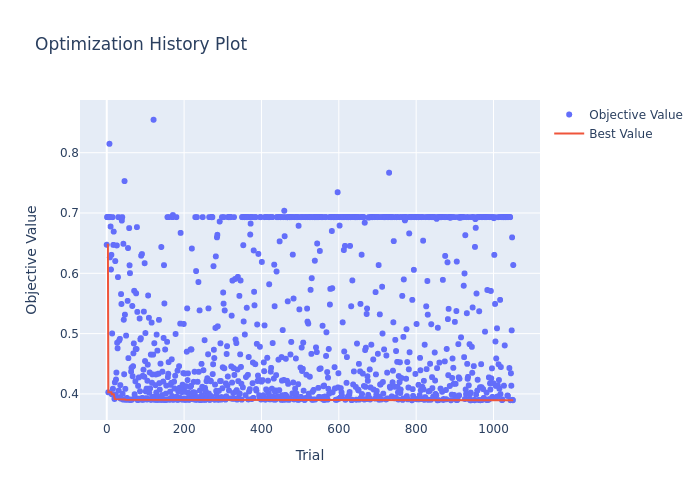

In [11]:
plot_optimization_history(study)

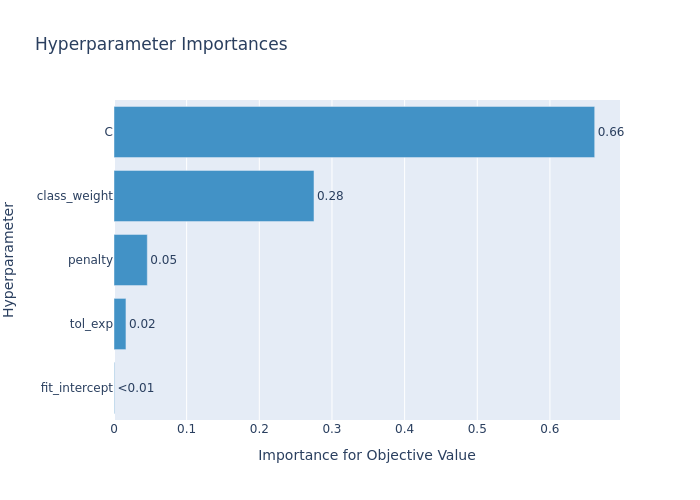

In [12]:
plot_param_importances(study)

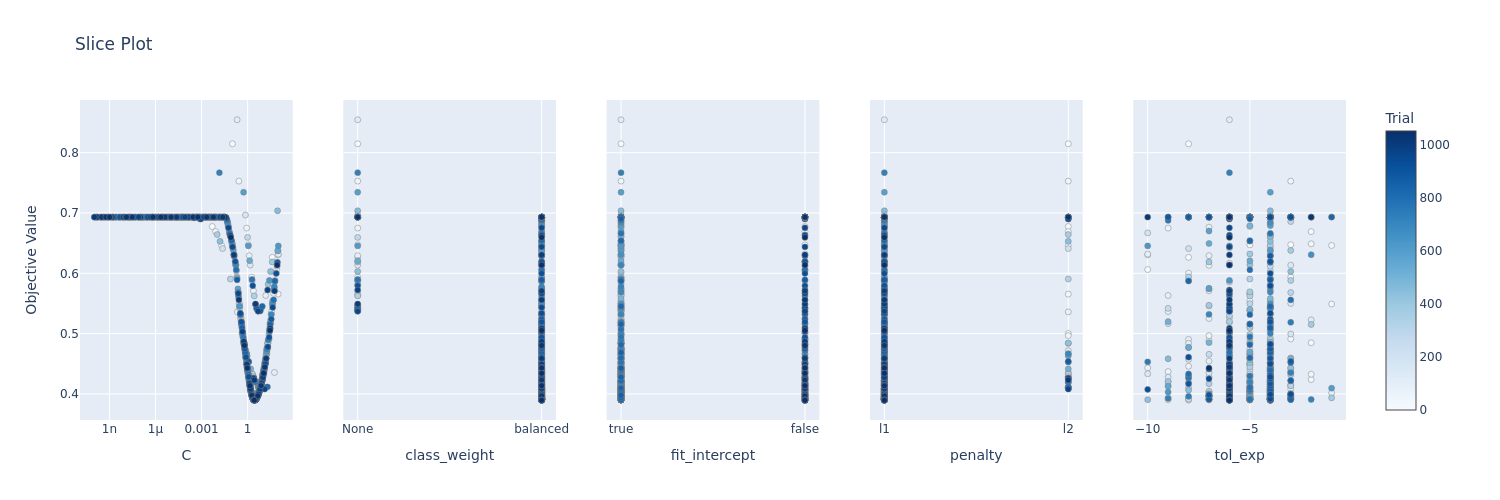

In [13]:
plot_slice(study)

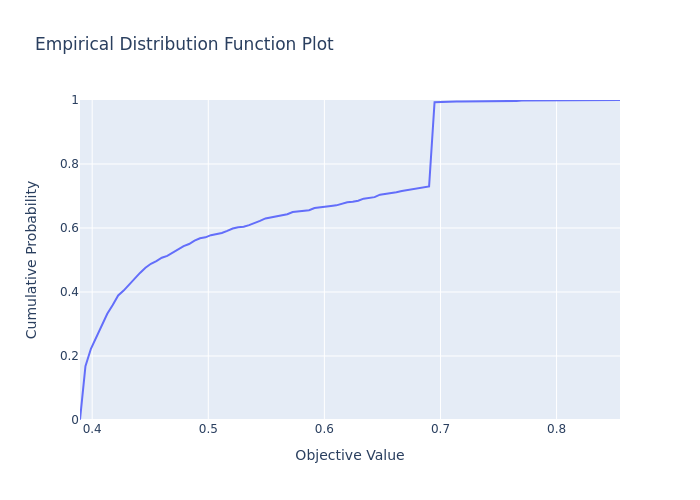

In [14]:
plot_edf(study)

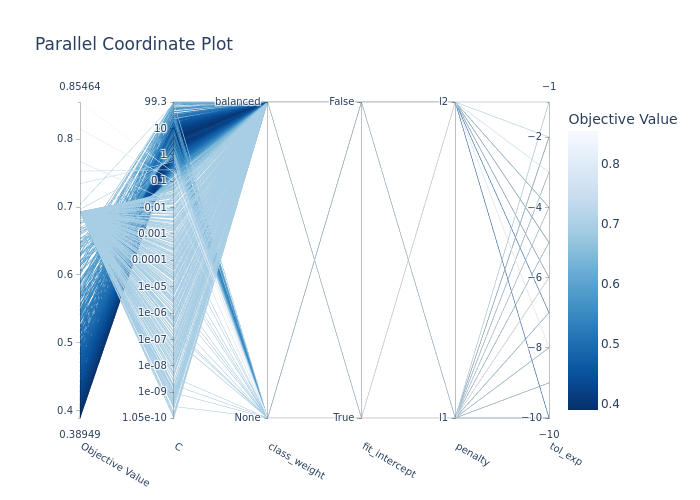

In [15]:
plot_parallel_coordinate(study)

In [16]:
best_params = dict(study.best_params)
best_params["tol"] = 10**best_params.pop("tol_exp")
best_params

{'C': 2.736787672462635,
 'class_weight': 'balanced',
 'fit_intercept': False,
 'penalty': 'l1',
 'tol': 0.0001}

***